# Prediction and Forecasting Results in the English Premier League

## Transfermarkt value

The object this week is to forecast the outcome of soccer games. We are going to show how to do this using the English Premier League as our example. However, you could easily adapt our method to professional soccer leagues around the world. 

We learnt in Course 1 that player salaries in the English Premier League are closely correlated with team performance in the league (see Course 1, Week 5). This reflects the nature of the market. It's not that higher salaries get players to try harder (most professional soccer players don't need much motivation). Rather, there is a market for players with many buyers and sellers, and the ability of players is realtively easy to order, so that each player commands a salary relative to other players that matches his position in the hierarchy of ability (more or less).

We can obtain data on salary spending of EPL clubs from their financial statements which are freely available online from the website of Companies House. However, this is little use to us if we want to forecast the results of games, since the financial statements are not published until at least six months after the season ends (and often a lot longer). While wages are a good predictor of results because they reflect the ability of players, from one season to the next teams trade players, so last year's wages will not be a good predictor of this year's performance.

To make forecasts, we need something that is as reliable as the wage data, but is contemporaneous with the games being played. Fortunately, we have something.

Transfermarkt is website that provides a valuation for thousands of professional players for dozens of leagues around the world (it has various handles for its website, such as https://www.transfermarkt.de/, https://www.transfermarkt.us/, https://www.transfermarkt.co.uk/, https://www.transfermarkt.fr/). The value is an estimate or the transfer price that would be paid for a player to move from one club to another. The valuations are updated at regular intervals, and are generated by a version of "crowdsourcing" - aggregating the opinions of many different individuals. Here is a description of the method:

"Transfermarkt.de, Germany’s leading online soccer community and one of the largest sport websites on the German language Internet, applies the judge principle. Every interested person can register for free on the transfermarkt.de community and discuss market values of thousands of soccer players playing in various countries and divisions. Commonly, a member proposes a market value for a player and provides a rationale for this number, for example, by arguing about one or more of the player’s attributes to justify his or her market-value estimation. Every community member can follow the discussion threads of all the players’ market values and users can contribute based on criteria that are most important to them personally. However, only a few merited community members are discussion leaders – ‘‘judges’’ in the language of our research. Judges have earned superior rights and make the final decisions about market-value suggestions that are posted by community members."

(Herm, S., Callsen-Bracker, H. M., & Kreis, H. (2014). When the crowd evaluates soccer players’ market values: Accuracy and evaluation attributes of an online community. Sport Management Review, 17(4), 484-492).

Relying on these subjective valuations would be a leap of faith without first checking that they are correlated with an objective measure of value. Here we check the total transfermarkt values of team squads from past years with the measures of wages and salaries taken from the financial statements of the Premier League clubs.

To do this we will use a datafile of Premier League club wages and merge it with a datafile TM values. We will look at the correlation by means of a scatter diagram, and then run a regression to see how closely the two datasets fit.

We now import two datasets, one with the wage data from the financial statements, the other with the values from Transfermarkt (TM). Note that the seasons covered by the two datasets are not identical. When working with data on leagues whose seasons start and end in different calendar years its important to be sure which season you are referring to. For the TM data the filename refers to both years- e.g. the season 2010-11. For the wage data it just refers to single year for each season - e.g. 2018. Here our convention when using a single year to refer to a season is the identify the year in which the season ended, e.g. 2018 refers to the season 2017-18.

In [1]:
# Here we import the packages we will need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
wagedat_read =pd.read_excel("../Data/EPL club wages and position 1997-2018.xlsx")
TMdat_read = pd.read_excel("../Data/EPL TM values 2010-11 to 2019-20.xlsx")
gbygdat_read = pd.read_excel("../Data/EPL game results 2011-19 with odds.xlsx")
season19_20_read = pd.read_excel("../Data/EPL19-20.xlsx")

In [3]:
wagedat = wagedat_read.copy()
TMdat = TMdat_read.copy()

# Because of the promotion and relegation system, there are many more than 20 clubs in our data, even though there were only ever 20 clubs in the 
# Premier League in any one season. 
# We can see which clubs appeared by listing the unique elements of the "Club" variable in our wage data file.

wagedat['Club'].unique()

array(['Arsenal', 'Aston Villa', 'Barnsley', 'Birmingham City',
       'Blackburn Rovers', 'Blackpool', 'Bolton Wanderers', 'Bournemouth',
       'Bradford City', 'Brighton & Hove Albion', 'Burnley',
       'Cardiff City', 'Charlton Athletic', 'Chelsea', 'Coventry City',
       'Crystal Palace', 'Derby County', 'Everton', 'Fulham',
       'Huddersfield Town', 'Hull City', 'Ipswich Town', 'Leeds United',
       'Leicester City', 'Liverpool', 'Manchester City',
       'Manchester United', 'Middlesbrough', 'Newcastle United',
       'Norwich City', 'Nottingham Forest', 'Portsmouth',
       'Queens Park Rangers', 'Reading', 'Sheffield United',
       'Sheffield Wednesday', 'Southampton', 'Stoke City', 'Sunderland',
       'Swansea City', 'Tottenham Hotspur', 'Watford',
       'West Bromwich Albion', 'West Ham United', 'Wigan Athletic',
       'Wimbledon', 'Wolverhampton Wanderers'], dtype=object)

In [4]:
# Likewise we can list the unique elements of the "Club" variable in the TM data. Note this has fewer clubs, since the data covers a shorter period.

TMdat['Club'].unique()

array(['Arsenal', 'Aston Villa', 'Birmingham City', 'Blackburn Rovers',
       'Blackpool', 'Bolton Wanderers', 'Chelsea', 'Everton', 'Fulham',
       'Liverpool', 'Manchester City', 'Manchester United',
       'Newcastle United', 'Stoke City', 'Sunderland',
       'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United',
       'Wigan Athletic', 'Wolverhampton Wanderers', 'Norwich City',
       'Queens Park Rangers', 'Swansea City', 'Reading', 'Southampton',
       'Cardiff City', 'Crystal Palace', 'Hull City', 'Burnley',
       'Leicester City', 'Bournemouth', 'Watford', 'Middlesbrough',
       'Brighton & Hove Albion', 'Huddersfield Town', 'Sheffield United'],
      dtype=object)

In [5]:
# We can use .describe() to view the the dimensions of the wage data...

wagedat.describe(include='all')

,seasonyrend,Club,Position,wages
count,440.000000,440,440.000000,4.350000e+02
unique,NaN,47,NaN,NaN
top,NaN,Arsenal,NaN,NaN
freq,NaN,22,NaN,NaN
mean,2007.500000,NaN,10.500000,6.197073e+07
std,6.351511,NaN,5.772845,5.387372e+07
min,1997.000000,NaN,1.000000,4.172024e+06
25%,2002.000000,NaN,5.750000,2.640600e+07
50%,2007.500000,NaN,10.500000,4.529037e+07
75%,2013.000000,NaN,15.250000,7.754100e+07


In [6]:
# ...and the TM data

TMdat.describe(include='all')

,seasonyrbegin,seasonyrend,Club,TMValue
count,200.000000,200.000000,200,200.000000
unique,NaN,NaN,36,NaN
top,NaN,NaN,Arsenal,NaN
freq,NaN,NaN,10,NaN
mean,2014.500000,2015.500000,NaN,218.767100
std,2.879489,2.879489,NaN,198.041615
min,2010.000000,2011.000000,NaN,20.630000
25%,2012.000000,2013.000000,NaN,82.182500
50%,2014.500000,2015.500000,NaN,141.640000
75%,2017.000000,2018.000000,NaN,299.310000


To compare the wage bill of each club with its TM value we need to do a merge, so we must first create a unique id in each df. We can do this by concatenating 'Club' and 'seasonyrend' in each df to create such an id. Note that for this to work the names have to be compatible. An easy mistake when merging files is to have different names for the same team. e.g. some sources might refer to "Manchester City" while others might abbreviate this to "Man City". Here the names were pre-checked to make sure they are compatible.

In [7]:
wagedat['teamid'] = wagedat['Club']+wagedat['seasonyrend'].map(str)
wagedat

,seasonyrend,Club,Position,wages,teamid
0,1997,Arsenal,3,15279000.0,Arsenal1997
1,1998,Arsenal,1,21882000.0,Arsenal1998
2,1999,Arsenal,2,26478000.0,Arsenal1999
3,2000,Arsenal,2,33970000.0,Arsenal2000
4,2001,Arsenal,2,40651000.0,Arsenal2001
...,...,...,...,...,...
435,2000,Wimbledon,18,15770522.0,Wimbledon2000
436,2004,Wolverhampton Wanderers,20,19278845.0,Wolverhampton Wanderers2004
437,2010,Wolverhampton Wanderers,15,29800808.0,Wolverhampton Wanderers2010
438,2011,Wolverhampton Wanderers,17,37915000.0,Wolverhampton Wanderers2011


In [8]:
# create the same team/year id in TMdat

TMdat['teamid'] = TMdat['Club']+TMdat['seasonyrend'].map(str)
TMdat

,seasonyrbegin,seasonyrend,Club,TMValue,teamid
0,2010,2011,Arsenal,272.70,Arsenal2011
1,2010,2011,Aston Villa,127.94,Aston Villa2011
2,2010,2011,Birmingham City,68.00,Birmingham City2011
3,2010,2011,Blackburn Rovers,65.93,Blackburn Rovers2011
4,2010,2011,Blackpool,24.37,Blackpool2011
...,...,...,...,...,...
195,2019,2020,Southampton,209.70,Southampton2020
196,2019,2020,Tottenham Hotspur,881.55,Tottenham Hotspur2020
197,2019,2020,Watford,214.52,Watford2020
198,2019,2020,West Ham United,299.03,West Ham United2020


We can now use pd.merge. By listing TMdat first we merge the data from wagedat into TMdat. We specify the variables to be added in the merge ('teamid' and'wages'), and specify the common variable which aligns the two dfs ('teamid').

In [9]:
TMdat = pd.merge(TMdat,wagedat[['teamid','wages']], on= 'teamid', how = 'left')
TMdat

,seasonyrbegin,seasonyrend,Club,TMValue,teamid,wages
0,2010,2011,Arsenal,272.70,Arsenal2011,124401000.0
1,2010,2011,Aston Villa,127.94,Aston Villa2011,83395000.0
2,2010,2011,Birmingham City,68.00,Birmingham City2011,45088340.0
3,2010,2011,Blackburn Rovers,65.93,Blackburn Rovers2011,49869577.0
4,2010,2011,Blackpool,24.37,Blackpool2011,26014248.0
...,...,...,...,...,...,...
195,2019,2020,Southampton,209.70,Southampton2020,NaN
196,2019,2020,Tottenham Hotspur,881.55,Tottenham Hotspur2020,NaN
197,2019,2020,Watford,214.52,Watford2020,NaN
198,2019,2020,West Ham United,299.03,West Ham United2020,NaN


## Self Test - 1

Create the merged file but include the 'Position' variable from the wagedat df as well.

In [10]:
#Your Code Here
TMdat = pd.merge(TMdat[['teamid','TMValue','seasonyrend']],wagedat[['teamid','wages', 'Position']], on= 'teamid', how = 'left')
TMdat

,teamid,TMValue,seasonyrend,wages,Position
0,Arsenal2011,272.70,2011,124401000.0,4.0
1,Aston Villa2011,127.94,2011,83395000.0,9.0
2,Birmingham City2011,68.00,2011,45088340.0,18.0
3,Blackburn Rovers2011,65.93,2011,49869577.0,15.0
4,Blackpool2011,24.37,2011,26014248.0,19.0
...,...,...,...,...,...
195,Southampton2020,209.70,2020,NaN,NaN
196,Tottenham Hotspur2020,881.55,2020,NaN,NaN
197,Watford2020,214.52,2020,NaN,NaN
198,West Ham United2020,299.03,2020,NaN,NaN


In [11]:
# The TM data is expressed in £ million, while the wage data is in £. We can convert to common units by dividing wages by 1 million, 
# although this is not strictly necessary for the purpose of measuring correlation.

TMdat['wages']=TMdat['wages']/1000000
TMdat

,teamid,TMValue,seasonyrend,wages,Position
0,Arsenal2011,272.70,2011,124.401000,4.0
1,Aston Villa2011,127.94,2011,83.395000,9.0
2,Birmingham City2011,68.00,2011,45.088340,18.0
3,Blackburn Rovers2011,65.93,2011,49.869577,15.0
4,Blackpool2011,24.37,2011,26.014248,19.0
...,...,...,...,...,...
195,Southampton2020,209.70,2020,NaN,NaN
196,Tottenham Hotspur2020,881.55,2020,NaN,NaN
197,Watford2020,214.52,2020,NaN,NaN
198,West Ham United2020,299.03,2020,NaN,NaN


First, let's look at the correlation using a scatter diagram for all of the data. Using relplot in Seaborn (sns) we can see that the correlation is very close. Using "hue" helps us to see how the data varies by year, but in fact the pattern is pretty consistent across all years.

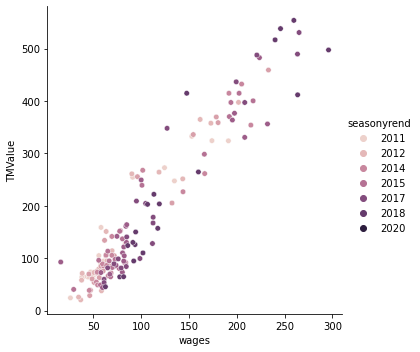

In [12]:
sns.relplot(x="wages", y="TMValue", data = TMdat, s=30, hue = "seasonyrend")

<AxesSubplot:xlabel='wages', ylabel='TMValue'>

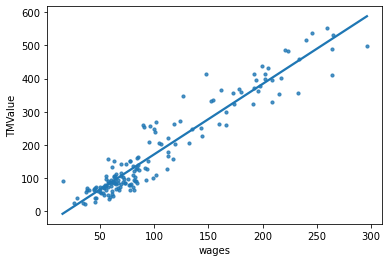

In [13]:
# If we use 'regplot' instead of 'relplot', we can add a regression line to the chart.

sns.regplot(x="wages", y="TMValue", data = TMdat, scatter_kws={'s':10}, ci = False)

## Self Test - 2

Generate a relplot or regplot for (a) wages and Position and (b) TMValue and Position.

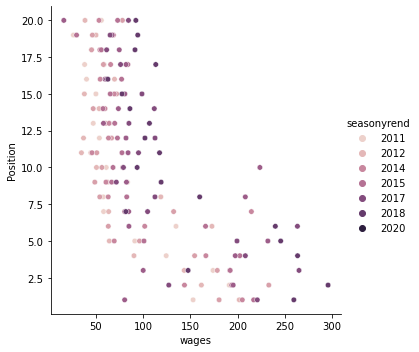

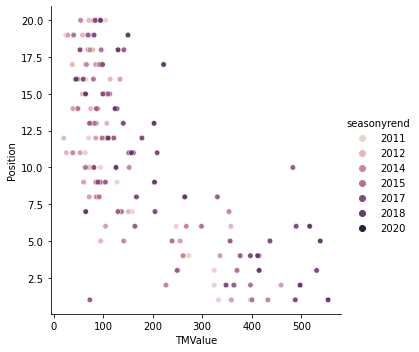

In [14]:
sns.relplot(x="wages", y="Position", data = TMdat, s=30, hue = "seasonyrend")
sns.relplot(x="TMValue", y="Position", data = TMdat, s=30, hue = "seasonyrend")

Having looked at the data, the next step is to run a regression to estimate exactly how closely the two data sets fit. We can run a regression for all eight seasons for which we have data:

In [15]:
TMwage_lm = smf.ols(formula = 'TMValue ~ wages', data=TMdat).fit()
TMwage_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                TMValue   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     1575.
Date:                Mon, 10 Jan 2022   Prob (F-statistic):           4.46e-84
Time:                        16:03:54   Log-Likelihood:                -823.24
No. Observations:                 160   AIC:                             1650.
Df Residuals:                     158   BIC:                             1657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -41.3114      6.418     -6.436      0.000     -53.988     -28.634
wages          2.1262      0.054     39.687      0.000       2.020       2.232
==============================================================================
Omnibus:                       11.482   Durbin-Watson:                   2.266
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.844
Skew:                           0.531   Prob(JB):                      0.00163
Kurtosis:                       3.893   Cond. No.                         233.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see from the regression that there is a very close fit. The R-Squared is 0.91 and the standard error of the wage coefficient is very small relative to the coefficient estimate, which a very large t-statistic and a p-value which is very small. Essentially the TM values for the players at any club is just over twice the value of the wage spending.

While this should reassure us that TM values are indeed reliable estimates of player market values, we should check to see that the estimates are consistent from year to year, and not subject to large fluctations. We can run a regression for each year, but for ease of comparison we want to use the same presentation method that we used in Course 2, reporting the coefficients estimates for each series in aligned columns. 

To do this we use the summary_col command, and add the extra lines which enable us to report the number of observations and R-Squared of the regression. 

First, we just report the regression for all seasons in this format:

In [16]:
from statsmodels.iolib.summary2 import summary_col
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}
TMwage_Out = summary_col(TMwage_lm,info_dict = info_dict)
print(TMwage_Out)


                 TMValue 
-------------------------
Intercept        -41.3114
                 (6.4184)
wages            2.1262  
                 (0.0536)
R-squared        0.9088  
R-squared Adj.   0.9083  
R-squared        0.91    
No. observations 160     
Standard errors in
parentheses.


We have eight seasons of data. We begin by defining eight dfs, each of which is a subset for a single season. Then we run the regression for each season. Then, we define headers for each column of our output (AllTM). Finally, we define the table of results and print this to display the results.

In [17]:
TM2011 = TMdat[TMdat.seasonyrend == 2011]
TM2012 = TMdat[TMdat.seasonyrend == 2012]
TM2013 = TMdat[TMdat.seasonyrend == 2013]
TM2014 = TMdat[TMdat.seasonyrend == 2014]
TM2015 = TMdat[TMdat.seasonyrend == 2015]
TM2016 = TMdat[TMdat.seasonyrend == 2016]
TM2017 = TMdat[TMdat.seasonyrend == 2017]
TM2018 = TMdat[TMdat.seasonyrend == 2018]

TM2011_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2011).fit()
TM2012_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2012).fit()
TM2013_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2013).fit()
TM2014_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2014).fit()
TM2015_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2015).fit()
TM2016_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2016).fit()
TM2017_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2017).fit()
TM2018_lm = smf.ols(formula = 'TMValue ~ wages', data=TM2018).fit()


AllTM = ["All",'2011','2012','2013','2014','2015','2016','2017','2018']

TMAll_Out = summary_col([TMwage_lm,TM2011_lm, TM2012_lm,TM2013_lm, TM2014_lm,TM2015_lm,TM2016_lm, TM2017_lm,TM2018_lm],\
                        model_names = AllTM, stars=True, info_dict = info_dict)

print(TMAll_Out)


                     All        2011      2012        2013       2014        2015       2016       2017       2018   
---------------------------------------------------------------------------------------------------------------------
Intercept        -41.3114*** -16.0649  -41.9445** -51.8969*** -42.3952** -55.7933*** -24.8110  -76.4519*** -72.4432**
                 (6.4184)    (13.9340) (14.6265)  (13.5827)   (16.9183)  (14.2330)   (21.0048) (22.2210)   (29.6730) 
wages            2.1262***   2.0355*** 2.3286***  2.2880***   2.1202***  2.2213***   1.9026*** 2.3548***   2.2253*** 
                 (0.0536)    (0.1507)  (0.1541)   (0.1303)    (0.1550)   (0.1228)    (0.1683)  (0.1574)    (0.1857)  
R-squared        0.9088      0.9102    0.9270     0.9448      0.9123     0.9478      0.8766    0.9256      0.8886    
R-squared Adj.   0.9083      0.9052    0.9229     0.9418      0.9074     0.9450      0.8697    0.9214      0.8825    
R-squared        0.91        0.91      0.93       0.94 

From the table we can see that the coefficient on wages is relatively stable from year to year, varying between 1.90 (2016) and 2.35 (2017). In each season the R-Squared implies a very close correlation.

## Self Test - 3

Run a regression of Position on (a) wages and (b) TMValue for all the seasons combined (i.e. not season by season) and compare the two regressions. What do you notice? 

In [18]:
wagePos_lm = smf.ols(formula = 'Position ~ wages', data=TMdat).fit()
display(wagePos_lm.summary())
TMPos_lm = smf.ols(formula = 'Position ~ TMValue', data=TMdat).fit()
display(TMPos_lm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Position   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     147.5
Date:                Mon, 10 Jan 2022   Prob (F-statistic):           2.17e-24
Time:                        16:03:55   Log-Likelihood:                -454.61
No. Observations:                 160   AIC:                             913.2
Df Residuals:                     158   BIC:                             919.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.1741      0.641     26.793      0.000      15.908      18.440
wages         -0.0650      0.005    -12.144      0.000      -0.076      -0.054
==============================================================================
Omnibus:                        9.740   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                4.088
Skew:                          -0.016   Prob(JB):                        0.130
Kurtosis:                       2.218   Cond. No.                         233.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Position   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     193.6
Date:                Mon, 10 Jan 2022   Prob (F-statistic):           3.05e-29
Time:                        16:03:55   Log-Likelihood:                -443.36
No. Observations:                 160   AIC:                             890.7
Df Residuals:                     158   BIC:                             896.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.0097      0.501     31.933      0.000      15.020      17.000
TMValue       -0.0311      0.002    -13.915      0.000      -0.036      -0.027
==============================================================================
Omnibus:                        0.457   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.796   Jarque-Bera (JB):                0.596
Skew:                          -0.008   Prob(JB):                        0.742
Kurtosis:                       2.701   Cond. No.                         366.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Conclusion

This exercise should give us confidence that TM values can be used as a measure of player quality, since they are closely correlated with club wage bills, which we have already established are a good predictor of team performance. 

We will now explore how good the TM data is at predicting past results, before going to to show how the model can be used to predict future results.


# Within Sample Prediction

Our ultimate goal is to create a model that can be used to predict events that have not yet happened. Before we do that, however, we ought to check first whether our model fits the data from the past. It's not impossible that a model which fits the historical record badly can be a good forecasting model, (especially if the world is changing dramatically), but under most circumstances, we should expect a model to work going backwards as well as forwards.

As outlined in the previous session, we're going to use the Transfermarkt (TM) data for forecasting, and we've already seen that the TM data for 2011-2018 fits the wage data from the financial statements well. So now let's see how well the TM data performs when explaining the variation of game results in the Premier League.

What should we expect? Anyone hoping for anything close to a 100% fit should give up now. If any sport were that predictable, then it would be no fun to watch in the first place. Even if some aspects of the game seem highly predictable, surprises happen all the time at the level of the individual game.

The accuracy of bookmakers is a much better standard to consider. Bookmakers make money by setting the odds correctly- if they get them badly wrong then punters can bet against them and make easy money, which will also make the bookmaker bankrupt. The only bookmakers we see are the ones that have not gone bankrupt, so it is reasonable to think that they are getting odds right on average. What does that mean? Odds are probabilities, and a bookmaker makes money by offering probabilities that are (more or less) correct on average. So if we use our model to generate probabilities, we can compare them with bookmaker probabilities, and see how close our model gets.

Reality check: if we could build a model much better than the bookmakers, then we wouldn't be academics, we'd be multi-millionaire gamblers living in the Bahamas. Some people claim to have built a model that can systematically beat the bookmakers, but such people seldom offer to show you the model. There's an entire business built around *telling* people you've built a model that beats the bookmakers, and then scamming these people for money. 

Think of it this way- for any game there are "true" probabilities, and the business of bookmakers is to get as close to these true probabilities as possible. In general, the bookmaker odds are close to the true probabilities, so if we have built a good model it can get close to the bookmaker probabilities.

What we will show in this notebook is that, perhaps surprisingly, it's not very difficult to get close.

There are three steps in this process:

    Step 1: Calculate the accuracy of betting odds in predicting outcomes.
    Step 2: Calculate predictions based on a model using the TMvalues.
    Step 3: Compare betting odds and our model's predictions using these metrics: (a) correct outcome (b) Brier score

But first, as always we set up our data.

We will use two datasets. TMdat we used in the last session, and now we also load a df of game results for the Premier League for seasons 2010/11 to 2018/19:

In [19]:
gbygdat = gbygdat_read.copy()
TMdat = TMdat_read.copy()

Looking at a gbygdat, you can see that it lists 3420 games. It identifies the season, home team and away team. FTHG is the total goals scored in the game by the home team, FTAG is the total goals scored by the away team. This is enough to tell us the result, but this is also provided in next column: H = home win, A = away win, D = draw (tie). 

In addition, we have the decimal odds on the three possible outcomes for each game, as offered before the game by the bookmaker Bet365. These odds can be obtained for free, along with the odds of many other bookmakers, for many different leagues, at this website: https://www.football-data.co.uk/. 

Although we only use one bookmaker as our benchmark, the odds set by all the bookmakers are typically very close together, rather in the same way that the exchange rate for currency trades offered by a broker is very close to that offered by all other brokers. If that were not the case, there would be an easy opportunity to make money through arbitrage, which means buying from one broker and selling to another, making a profit without taking any risk. The opportunity to make arbitrage profits in bookmaking is not unknown, but is very rare.

## Step 1: Calculate the accuracy of betting odds in predicting outcomes

We want to convert the bookmaker odds to probabilities and see how accurate they are. The odds are in decimal format, and therefore the outcome probability equals 1/(decimal odds).  However, if you make this calculation and sum the three possibilities the total is greater than one.  This is called the 'overround', or the 'vig' - and represents the profit of the bookmaker. To calculate the implied probability from the betting odds you have to divide by the sum of the three numbers, so that your final probabilities do add up to 1 (100%).

We calculate these probabilities below:

In [20]:
gbygdat['B365HPr']= 1/(gbygdat['B365H'])/(1/(gbygdat['B365H'])+ 1/(gbygdat['B365D'])+ 1/(gbygdat['B365A']))
gbygdat['B365DPr']= 1/(gbygdat['B365D'])/(1/(gbygdat['B365H'])+ 1/(gbygdat['B365D'])+ 1/(gbygdat['B365A']))
gbygdat['B365APr']= 1/(gbygdat['B365A'])/(1/(gbygdat['B365H'])+ 1/(gbygdat['B365D'])+ 1/(gbygdat['B365A']))
gbygdat

,seasonyrend,home_team,away_team,FTHG,FTAG,FTR,B365H,B365D,B365A,B365HPr,B365DPr,B365APr
0,2011,Aston Villa,Arsenal,2,4,A,3.40,3.30,2.20,0.279661,0.288136,0.432203
1,2011,Birmingham City,Arsenal,0,3,A,5.50,3.60,1.67,0.171786,0.262451,0.565763
2,2011,Blackburn Rovers,Arsenal,1,2,A,6.00,4.00,1.57,0.158186,0.237280,0.604534
3,2011,Blackpool,Arsenal,1,3,A,8.50,5.00,1.36,0.111732,0.189944,0.698324
4,2011,Bolton Wanderers,Arsenal,2,1,H,4.50,3.80,1.75,0.210277,0.249012,0.540711
...,...,...,...,...,...,...,...,...,...,...,...,...
3415,2019,Wolverhampton Wanderers,Newcastle United,1,1,D,1.70,3.75,5.75,0.571760,0.259198,0.169042
3416,2019,Wolverhampton Wanderers,Southampton,2,0,H,1.80,3.60,5.25,0.542636,0.271318,0.186047
3417,2019,Wolverhampton Wanderers,Tottenham Hotspur,2,3,A,3.10,3.40,2.45,0.314755,0.286983,0.398262
3418,2019,Wolverhampton Wanderers,Watford,0,2,A,1.75,3.75,5.25,0.555556,0.259259,0.185185


These are probabilities for each possible outcome. We can also say that the predicted outcome of any game is the one with the highest probability. We can use 'np.where' to identify the implied result from the probabilities. For example, if the probability of home win is greater than the probability of a draw AND the probability of home win is greater than the probability of an away win, then home win is the predicted outcome (H). 

Note: we could just as easily have generated this variable from the decimal odds, since the outcome with the lowest decimal odds has the highest probability.

In [21]:
gbygdat['B365res']= np.where((gbygdat['B365HPr']>gbygdat['B365DPr']) & (gbygdat['B365HPr']>gbygdat['B365APr']),'H',\
                            np.where((gbygdat['B365DPr']>gbygdat['B365HPr']) & (gbygdat['B365DPr']>gbygdat['B365APr']),'D','A'))
gbygdat

,seasonyrend,home_team,away_team,FTHG,FTAG,FTR,B365H,B365D,B365A,B365HPr,B365DPr,B365APr,B365res
0,2011,Aston Villa,Arsenal,2,4,A,3.40,3.30,2.20,0.279661,0.288136,0.432203,A
1,2011,Birmingham City,Arsenal,0,3,A,5.50,3.60,1.67,0.171786,0.262451,0.565763,A
2,2011,Blackburn Rovers,Arsenal,1,2,A,6.00,4.00,1.57,0.158186,0.237280,0.604534,A
3,2011,Blackpool,Arsenal,1,3,A,8.50,5.00,1.36,0.111732,0.189944,0.698324,A
4,2011,Bolton Wanderers,Arsenal,2,1,H,4.50,3.80,1.75,0.210277,0.249012,0.540711,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,2019,Wolverhampton Wanderers,Newcastle United,1,1,D,1.70,3.75,5.75,0.571760,0.259198,0.169042,H
3416,2019,Wolverhampton Wanderers,Southampton,2,0,H,1.80,3.60,5.25,0.542636,0.271318,0.186047,H
3417,2019,Wolverhampton Wanderers,Tottenham Hotspur,2,3,A,3.10,3.40,2.45,0.314755,0.286983,0.398262,A
3418,2019,Wolverhampton Wanderers,Watford,0,2,A,1.75,3.75,5.25,0.555556,0.259259,0.185185,H


What percentage of the time was the bookmaker's prediction correct? We can create a variable which equals one when the actual result (FTR) equals the bookmaker's prediction (B365res), and zero otherwise:

In [22]:
gbygdat['B365true']= np.where(gbygdat['B365res'] == gbygdat['FTR'],1,0)
gbygdat.describe(include='all')

,seasonyrend,home_team,away_team,FTHG,FTAG,FTR,B365H,B365D,B365A,B365HPr,B365DPr,B365APr,B365res,B365true
count,3420.000000,3420,3420,3420.000000,3420.000000,3420,3420.000000,3420.000000,3420.000000,3420.000000,3420.000000,3420.000000,3420,3420.000000
unique,NaN,35,35,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,Arsenal,Arsenal,NaN,NaN,H,NaN,NaN,NaN,NaN,NaN,NaN,H,NaN
freq,NaN,171,171,NaN,NaN,1565,NaN,NaN,NaN,NaN,NaN,NaN,2373,NaN
mean,2015.000000,NaN,NaN,1.556433,1.191813,NaN,2.830766,4.123731,5.037944,0.450754,0.248720,0.300526,NaN,0.544444
std,2.582366,NaN,NaN,1.304716,1.164475,NaN,2.039274,1.279006,4.313887,0.194380,0.049793,0.173229,NaN,0.498094
min,2011.000000,NaN,NaN,0.000000,0.000000,NaN,1.060000,3.000000,1.120000,0.042139,0.057020,0.023781,NaN,0.000000
25%,2013.000000,NaN,NaN,1.000000,0.000000,NaN,1.660000,3.400000,2.400000,0.314755,0.224913,0.169579,NaN,0.000000
50%,2015.000000,NaN,NaN,1.000000,1.000000,NaN,2.200000,3.600000,3.500000,0.441776,0.264999,0.271396,NaN,1.000000
75%,2017.000000,NaN,NaN,2.000000,2.000000,NaN,3.100000,4.330000,5.750000,0.585502,0.286816,0.397351,NaN,1.000000


The percentage of correct predictions is just the mean of this variable, B365true:

In [23]:
gbygdat['B365true'].mean()

0.5444444444444444

It's also interesting to compare the cases where the betting odds were "correct" (in the sense of attaching the highest probability to the actual outcome), to those were they were not. We can do this using the .groupby command for the variable 'B365true'. You can see below that when the betting odds were correct, on average the home team scored two goals to the away team's one, and that the home team had a higher probability of winning according to the betting odds. Where the bookmaker failed, the odds were more balanced and the outcome in terms of goals actually favoured the away team on average. This suggests that the bookmakers are better at correctly home wins when the home team is much stronger than the away team, and less successful at predicting close games where the away team often wins.

In [24]:
gbygdat.groupby('B365true').mean()

,seasonyrend,FTHG,FTAG,B365H,B365D,B365A,B365HPr,B365DPr,B365APr
B365true,,,,,,,,,
0,2014.897304,1.082157,1.296534,2.787651,3.776200,4.080969,0.420245,0.263857,0.315898
1,2015.085929,1.953276,1.104189,2.866842,4.414522,5.838679,0.476282,0.236054,0.287664


So, a 54% success rate represents a benchmark against which we can compare the result of our own model. Note that 54% is not necessarily that great. Suppose you picked at random, how many results would you get right? If you guessed on the basis that each outcome was equally likely, you'd be right about one-third of the time. So the range of reasonable success rates lies somewhere in the range of 33% (random) and 54% (the bookmakers).

Attaching the highest probability to the actual outcome is one measure of success, but as we discussed when looking at the betting odds, the Brier Score is a better measure, since it measures the closeness of predicted probabilities to the outcome.

So, let's now derive the Brier Score for the Bet365 data. Recall that the Brier score is defined as the sum of squared differences between the value of each actual outcome (which is one for the actual result, and zero for the two outcomes that were not realized) and the predicted probability of that outcome, all divided by the number of events predicted (which in our case is 3420 games).

First, we define a variable for each possible outcome, with the value 1 if this was the actual outcome and zero otherwise:

In [25]:
gbygdat['Houtcome']= np.where(gbygdat['FTR']=='H',1,0)
gbygdat['Doutcome']= np.where(gbygdat['FTR']=='D',1,0)
gbygdat['Aoutcome']= np.where(gbygdat['FTR']=='A',1,0)
gbygdat

,seasonyrend,home_team,away_team,FTHG,FTAG,FTR,B365H,B365D,B365A,B365HPr,B365DPr,B365APr,B365res,B365true,Houtcome,Doutcome,Aoutcome
0,2011,Aston Villa,Arsenal,2,4,A,3.40,3.30,2.20,0.279661,0.288136,0.432203,A,1,0,0,1
1,2011,Birmingham City,Arsenal,0,3,A,5.50,3.60,1.67,0.171786,0.262451,0.565763,A,1,0,0,1
2,2011,Blackburn Rovers,Arsenal,1,2,A,6.00,4.00,1.57,0.158186,0.237280,0.604534,A,1,0,0,1
3,2011,Blackpool,Arsenal,1,3,A,8.50,5.00,1.36,0.111732,0.189944,0.698324,A,1,0,0,1
4,2011,Bolton Wanderers,Arsenal,2,1,H,4.50,3.80,1.75,0.210277,0.249012,0.540711,A,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,2019,Wolverhampton Wanderers,Newcastle United,1,1,D,1.70,3.75,5.75,0.571760,0.259198,0.169042,H,0,0,1,0
3416,2019,Wolverhampton Wanderers,Southampton,2,0,H,1.80,3.60,5.25,0.542636,0.271318,0.186047,H,1,1,0,0
3417,2019,Wolverhampton Wanderers,Tottenham Hotspur,2,3,A,3.10,3.40,2.45,0.314755,0.286983,0.398262,A,1,0,0,1
3418,2019,Wolverhampton Wanderers,Watford,0,2,A,1.75,3.75,5.25,0.555556,0.259259,0.185185,H,0,0,0,1


Now calculate the Brier Score as the sum of the squared differences divided by the number of events:

In [26]:
BrierB365 = ((gbygdat['B365HPr'] - gbygdat['Houtcome'])**2 +(gbygdat['B365DPr'] - gbygdat['Doutcome'])**2 +\
             (gbygdat['B365APr'] - gbygdat['Aoutcome'])**2).sum()/3420 
BrierB365

0.568726835315728

This value has little meaning in its own right. Its value lies in providing a benchmark for the predictions which we will now generate using a model based on TM values.

## Step 2: Calculate predictions using the TM values

### The Model

We are going to use a very simple model: the probability that a team wins a game depends on (a) home advantage and (b) the ratio of the quality of the teams, as measured by the TM value. 

This model is simply the game level version of what we found out in Course 1, namely that teams whose player spending is higher are more likely to win. 

We need to estimate our model in order to identify exactly how much the probability of winning is affected by home advantage and relative team quality. To do this we are going to use a regression model, estimate the best fit between our explanatory variables (home advantage and TM ratio) and the dependent variable, which is the outcome of the game (H, D, A).

As we saw in the beginning of this course, the appropriate regression model for this situation is the ordered logit model, which estimates the probability of each possible outcome based on the data. These estimates, then, will be our model's prediction, and we can compare the accuracy of these estimates to the estimates implied by the betting odds above.

In our estimation, we will take the perspective of the home team. That means when the TM ratio will have the home team TM value in the numerator and the away team TM value in the denominator. This also means that the estimated intercept will be an indicator of home team advantage. In fact, if we use the logarithm of the TM ratio, when the two sides have equal spending the value will be zero (log(1) = 0) and hence the intercept can be interpreted as pure home advantage, independent of player spending.




### Organizing the data

Before running the regression we must first organize the data. We need to merge the files with the betting odds and the TM values (we will add the TM values to the gbygdat df). To do this we need to create a matching variable. If we create a variable which is the name of each club and the year value (e.g. Arsenal2011) then we can use this as the basis for merging the TM values in gbygdat.

This is as simple as just adding the two variable names together, although remembering that while the team names are already strings, the year values are integers, and to combine the names we need to treat integer values as strings.

We create one variable for the home team - 'hteamid' - and one for the away team - 'ateamid'.

In [27]:
# first we create the merge id in gbygdat

gbygdat['hteamid'] = gbygdat['home_team']+gbygdat['seasonyrend'].map(str)
gbygdat['ateamid'] = gbygdat['away_team']+gbygdat['seasonyrend'].map(str)

gbygdat

,seasonyrend,home_team,away_team,FTHG,FTAG,FTR,B365H,B365D,B365A,B365HPr,B365DPr,B365APr,B365res,B365true,Houtcome,Doutcome,Aoutcome,hteamid,ateamid
0,2011,Aston Villa,Arsenal,2,4,A,3.40,3.30,2.20,0.279661,0.288136,0.432203,A,1,0,0,1,Aston Villa2011,Arsenal2011
1,2011,Birmingham City,Arsenal,0,3,A,5.50,3.60,1.67,0.171786,0.262451,0.565763,A,1,0,0,1,Birmingham City2011,Arsenal2011
2,2011,Blackburn Rovers,Arsenal,1,2,A,6.00,4.00,1.57,0.158186,0.237280,0.604534,A,1,0,0,1,Blackburn Rovers2011,Arsenal2011
3,2011,Blackpool,Arsenal,1,3,A,8.50,5.00,1.36,0.111732,0.189944,0.698324,A,1,0,0,1,Blackpool2011,Arsenal2011
4,2011,Bolton Wanderers,Arsenal,2,1,H,4.50,3.80,1.75,0.210277,0.249012,0.540711,A,0,1,0,0,Bolton Wanderers2011,Arsenal2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,2019,Wolverhampton Wanderers,Newcastle United,1,1,D,1.70,3.75,5.75,0.571760,0.259198,0.169042,H,0,0,1,0,Wolverhampton Wanderers2019,Newcastle United2019
3416,2019,Wolverhampton Wanderers,Southampton,2,0,H,1.80,3.60,5.25,0.542636,0.271318,0.186047,H,1,1,0,0,Wolverhampton Wanderers2019,Southampton2019
3417,2019,Wolverhampton Wanderers,Tottenham Hotspur,2,3,A,3.10,3.40,2.45,0.314755,0.286983,0.398262,A,1,0,0,1,Wolverhampton Wanderers2019,Tottenham Hotspur2019
3418,2019,Wolverhampton Wanderers,Watford,0,2,A,1.75,3.75,5.25,0.555556,0.259259,0.185185,H,0,0,0,1,Wolverhampton Wanderers2019,Watford2019


Now we do the same thing in TMdat. For the purposes of matching, we need to match with the home team and the away team in the gbygdat, but in our TM file, we just have the TM value for each club. For each game, the club might be the home team or the away team. So we simply create two versions of the same variable and give them different names- hteamid and ateamid, which we can then use for the merge:

In [28]:
TMdat['hteamid'] = TMdat['Club']+TMdat['seasonyrend'].astype(str)
TMdat['ateamid'] = TMdat['Club']+TMdat['seasonyrend'].astype(str)

TMdat

,seasonyrbegin,seasonyrend,Club,TMValue,hteamid,ateamid
0,2010,2011,Arsenal,272.70,Arsenal2011,Arsenal2011
1,2010,2011,Aston Villa,127.94,Aston Villa2011,Aston Villa2011
2,2010,2011,Birmingham City,68.00,Birmingham City2011,Birmingham City2011
3,2010,2011,Blackburn Rovers,65.93,Blackburn Rovers2011,Blackburn Rovers2011
4,2010,2011,Blackpool,24.37,Blackpool2011,Blackpool2011
...,...,...,...,...,...,...
195,2019,2020,Southampton,209.70,Southampton2020,Southampton2020
196,2019,2020,Tottenham Hotspur,881.55,Tottenham Hotspur2020,Tottenham Hotspur2020
197,2019,2020,Watford,214.52,Watford2020,Watford2020
198,2019,2020,West Ham United,299.03,West Ham United2020,West Ham United2020


So now we can do two merges, one for hteamid and the other for ateamid. We are merging just the TMvalue column into the gbygdat df, using each of the teamids.

We merge on hteamid first. We will rename the TM value column hTM to denote that it is the value matched for the home team:

In [29]:
gbygdat = pd.merge(gbygdat,TMdat[['hteamid','TMValue']], on= 'hteamid', how = 'left').rename(columns={'TMValue':'hTM'})
gbygdat

,seasonyrend,home_team,away_team,FTHG,FTAG,FTR,B365H,B365D,B365A,B365HPr,B365DPr,B365APr,B365res,B365true,Houtcome,Doutcome,Aoutcome,hteamid,ateamid,hTM
0,2011,Aston Villa,Arsenal,2,4,A,3.40,3.30,2.20,0.279661,0.288136,0.432203,A,1,0,0,1,Aston Villa2011,Arsenal2011,127.94
1,2011,Birmingham City,Arsenal,0,3,A,5.50,3.60,1.67,0.171786,0.262451,0.565763,A,1,0,0,1,Birmingham City2011,Arsenal2011,68.00
2,2011,Blackburn Rovers,Arsenal,1,2,A,6.00,4.00,1.57,0.158186,0.237280,0.604534,A,1,0,0,1,Blackburn Rovers2011,Arsenal2011,65.93
3,2011,Blackpool,Arsenal,1,3,A,8.50,5.00,1.36,0.111732,0.189944,0.698324,A,1,0,0,1,Blackpool2011,Arsenal2011,24.37
4,2011,Bolton Wanderers,Arsenal,2,1,H,4.50,3.80,1.75,0.210277,0.249012,0.540711,A,0,1,0,0,Bolton Wanderers2011,Arsenal2011,74.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,2019,Wolverhampton Wanderers,Newcastle United,1,1,D,1.70,3.75,5.75,0.571760,0.259198,0.169042,H,0,0,1,0,Wolverhampton Wanderers2019,Newcastle United2019,178.02
3416,2019,Wolverhampton Wanderers,Southampton,2,0,H,1.80,3.60,5.25,0.542636,0.271318,0.186047,H,1,1,0,0,Wolverhampton Wanderers2019,Southampton2019,178.02
3417,2019,Wolverhampton Wanderers,Tottenham Hotspur,2,3,A,3.10,3.40,2.45,0.314755,0.286983,0.398262,A,1,0,0,1,Wolverhampton Wanderers2019,Tottenham Hotspur2019,178.02
3418,2019,Wolverhampton Wanderers,Watford,0,2,A,1.75,3.75,5.25,0.555556,0.259259,0.185185,H,0,0,0,1,Wolverhampton Wanderers2019,Watford2019,178.02


Now we merge on ateamid. We will rename the TM value column aTM to denote that it is the value matched for the away team:

In [30]:
gbygdat = pd.merge(gbygdat,TMdat[['ateamid','TMValue']], on= 'ateamid', how = 'left').rename(columns={'TMValue':'aTM'})
gbygdat

,seasonyrend,home_team,away_team,FTHG,FTAG,FTR,B365H,B365D,B365A,B365HPr,...,B365APr,B365res,B365true,Houtcome,Doutcome,Aoutcome,hteamid,ateamid,hTM,aTM
0,2011,Aston Villa,Arsenal,2,4,A,3.40,3.30,2.20,0.279661,...,0.432203,A,1,0,0,1,Aston Villa2011,Arsenal2011,127.94,272.70
1,2011,Birmingham City,Arsenal,0,3,A,5.50,3.60,1.67,0.171786,...,0.565763,A,1,0,0,1,Birmingham City2011,Arsenal2011,68.00,272.70
2,2011,Blackburn Rovers,Arsenal,1,2,A,6.00,4.00,1.57,0.158186,...,0.604534,A,1,0,0,1,Blackburn Rovers2011,Arsenal2011,65.93,272.70
3,2011,Blackpool,Arsenal,1,3,A,8.50,5.00,1.36,0.111732,...,0.698324,A,1,0,0,1,Blackpool2011,Arsenal2011,24.37,272.70
4,2011,Bolton Wanderers,Arsenal,2,1,H,4.50,3.80,1.75,0.210277,...,0.540711,A,0,1,0,0,Bolton Wanderers2011,Arsenal2011,74.93,272.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,2019,Wolverhampton Wanderers,Newcastle United,1,1,D,1.70,3.75,5.75,0.571760,...,0.169042,H,0,0,1,0,Wolverhampton Wanderers2019,Newcastle United2019,178.02,159.03
3416,2019,Wolverhampton Wanderers,Southampton,2,0,H,1.80,3.60,5.25,0.542636,...,0.186047,H,1,1,0,0,Wolverhampton Wanderers2019,Southampton2019,178.02,239.72
3417,2019,Wolverhampton Wanderers,Tottenham Hotspur,2,3,A,3.10,3.40,2.45,0.314755,...,0.398262,A,1,0,0,1,Wolverhampton Wanderers2019,Tottenham Hotspur2019,178.02,751.05
3418,2019,Wolverhampton Wanderers,Watford,0,2,A,1.75,3.75,5.25,0.555556,...,0.185185,H,0,0,0,1,Wolverhampton Wanderers2019,Watford2019,178.02,148.68


For our regression we want to use the logarithm of the ratio of hTM to aTM, so we create this variable next:

In [31]:
gbygdat['lhTMratio'] = np.log(gbygdat['hTM']/gbygdat['aTM'])
gbygdat

,seasonyrend,home_team,away_team,FTHG,FTAG,FTR,B365H,B365D,B365A,B365HPr,...,B365res,B365true,Houtcome,Doutcome,Aoutcome,hteamid,ateamid,hTM,aTM,lhTMratio
0,2011,Aston Villa,Arsenal,2,4,A,3.40,3.30,2.20,0.279661,...,A,1,0,0,1,Aston Villa2011,Arsenal2011,127.94,272.70,-0.756811
1,2011,Birmingham City,Arsenal,0,3,A,5.50,3.60,1.67,0.171786,...,A,1,0,0,1,Birmingham City2011,Arsenal2011,68.00,272.70,-1.388865
2,2011,Blackburn Rovers,Arsenal,1,2,A,6.00,4.00,1.57,0.158186,...,A,1,0,0,1,Blackburn Rovers2011,Arsenal2011,65.93,272.70,-1.419779
3,2011,Blackpool,Arsenal,1,3,A,8.50,5.00,1.36,0.111732,...,A,1,0,0,1,Blackpool2011,Arsenal2011,24.37,272.70,-2.415019
4,2011,Bolton Wanderers,Arsenal,2,1,H,4.50,3.80,1.75,0.210277,...,A,0,1,0,0,Bolton Wanderers2011,Arsenal2011,74.93,272.70,-1.291818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,2019,Wolverhampton Wanderers,Newcastle United,1,1,D,1.70,3.75,5.75,0.571760,...,H,0,0,1,0,Wolverhampton Wanderers2019,Newcastle United2019,178.02,159.03,0.112803
3416,2019,Wolverhampton Wanderers,Southampton,2,0,H,1.80,3.60,5.25,0.542636,...,H,1,1,0,0,Wolverhampton Wanderers2019,Southampton2019,178.02,239.72,-0.297576
3417,2019,Wolverhampton Wanderers,Tottenham Hotspur,2,3,A,3.10,3.40,2.45,0.314755,...,A,1,0,0,1,Wolverhampton Wanderers2019,Tottenham Hotspur2019,178.02,751.05,-1.439576
3418,2019,Wolverhampton Wanderers,Watford,0,2,A,1.75,3.75,5.25,0.555556,...,H,0,0,0,1,Wolverhampton Wanderers2019,Watford2019,178.02,148.68,0.180100


Finally, in order to run the regression, the package we need to use requires the ordered variable (H, D, A) to be given a numeric value. We can do this by defining a new variable, win value, which equal 2 if H, 1 if D and 0 if A. This is what the next line of code does:

In [32]:
gbygdat['winvalue'] = np.where(gbygdat['FTR'] == 'H', 2,(np.where(gbygdat['FTR'] == 'D', 1, 0)))
gbygdat

,seasonyrend,home_team,away_team,FTHG,FTAG,FTR,B365H,B365D,B365A,B365HPr,...,B365true,Houtcome,Doutcome,Aoutcome,hteamid,ateamid,hTM,aTM,lhTMratio,winvalue
0,2011,Aston Villa,Arsenal,2,4,A,3.40,3.30,2.20,0.279661,...,1,0,0,1,Aston Villa2011,Arsenal2011,127.94,272.70,-0.756811,0
1,2011,Birmingham City,Arsenal,0,3,A,5.50,3.60,1.67,0.171786,...,1,0,0,1,Birmingham City2011,Arsenal2011,68.00,272.70,-1.388865,0
2,2011,Blackburn Rovers,Arsenal,1,2,A,6.00,4.00,1.57,0.158186,...,1,0,0,1,Blackburn Rovers2011,Arsenal2011,65.93,272.70,-1.419779,0
3,2011,Blackpool,Arsenal,1,3,A,8.50,5.00,1.36,0.111732,...,1,0,0,1,Blackpool2011,Arsenal2011,24.37,272.70,-2.415019,0
4,2011,Bolton Wanderers,Arsenal,2,1,H,4.50,3.80,1.75,0.210277,...,0,1,0,0,Bolton Wanderers2011,Arsenal2011,74.93,272.70,-1.291818,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,2019,Wolverhampton Wanderers,Newcastle United,1,1,D,1.70,3.75,5.75,0.571760,...,0,0,1,0,Wolverhampton Wanderers2019,Newcastle United2019,178.02,159.03,0.112803,1
3416,2019,Wolverhampton Wanderers,Southampton,2,0,H,1.80,3.60,5.25,0.542636,...,1,1,0,0,Wolverhampton Wanderers2019,Southampton2019,178.02,239.72,-0.297576,2
3417,2019,Wolverhampton Wanderers,Tottenham Hotspur,2,3,A,3.10,3.40,2.45,0.314755,...,1,0,0,1,Wolverhampton Wanderers2019,Tottenham Hotspur2019,178.02,751.05,-1.439576,0
3418,2019,Wolverhampton Wanderers,Watford,0,2,A,1.75,3.75,5.25,0.555556,...,0,0,0,1,Wolverhampton Wanderers2019,Watford2019,178.02,148.68,0.180100,0


Our df has a lot of variables, many of which we do not need, so for the sake of tidying up, we now drop some variables. Note that the ones we drop could easily be recreated using the variables that remain.

In [33]:
gbygdat= gbygdat.drop(columns= ['seasonyrend', 'home_team', 'away_team','B365H','B365D','B365A'])
gbygdat

,FTHG,FTAG,FTR,B365HPr,B365DPr,B365APr,B365res,B365true,Houtcome,Doutcome,Aoutcome,hteamid,ateamid,hTM,aTM,lhTMratio,winvalue
0,2,4,A,0.279661,0.288136,0.432203,A,1,0,0,1,Aston Villa2011,Arsenal2011,127.94,272.70,-0.756811,0
1,0,3,A,0.171786,0.262451,0.565763,A,1,0,0,1,Birmingham City2011,Arsenal2011,68.00,272.70,-1.388865,0
2,1,2,A,0.158186,0.237280,0.604534,A,1,0,0,1,Blackburn Rovers2011,Arsenal2011,65.93,272.70,-1.419779,0
3,1,3,A,0.111732,0.189944,0.698324,A,1,0,0,1,Blackpool2011,Arsenal2011,24.37,272.70,-2.415019,0
4,2,1,H,0.210277,0.249012,0.540711,A,0,1,0,0,Bolton Wanderers2011,Arsenal2011,74.93,272.70,-1.291818,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,1,1,D,0.571760,0.259198,0.169042,H,0,0,1,0,Wolverhampton Wanderers2019,Newcastle United2019,178.02,159.03,0.112803,1
3416,2,0,H,0.542636,0.271318,0.186047,H,1,1,0,0,Wolverhampton Wanderers2019,Southampton2019,178.02,239.72,-0.297576,2
3417,2,3,A,0.314755,0.286983,0.398262,A,1,0,0,1,Wolverhampton Wanderers2019,Tottenham Hotspur2019,178.02,751.05,-1.439576,0
3418,0,2,A,0.555556,0.259259,0.185185,H,0,0,0,1,Wolverhampton Wanderers2019,Watford2019,178.02,148.68,0.180100,0


### Estimation

Now we've organized the data we're ready to run the regressions.

In week 1 we encountered the ordered logistic regression, which enables us to estimate the relationship between a dependent variable and independent variable, where the dependent variable consists of a fixed number of discrete possibilities. Here these possibilities are win, draw or lose. 

From the logistic regression, we can identify the probability associated with each possible outcome, as a function of our independent variables. In our case, we will estimate that probability for each of the three possible results for every game in our dataset, depending on the ratio of the TM value of the home team to the TM value of the away team (lhTMratio). 

First, we install the package we need to run the regression:

In [34]:
# This is the package we need to run the ordered logit

from bevel.linear_ordinal_regression import OrderedLogit
ol = OrderedLogit()

The regression command is ol.fit, and we specify first the explanatory variable (lhTMratio) and the dependent variable (winvalue).

Unlike the linear regression model which also gives us a constant for the regression, the ordered logit gives us estimates of thresholds between ordered groups (2, 1 and 0, signifying H, D, A). These estimates can then be used to generate estimates of H, D, A assuming that the explanatory variable lhTMratio has a value of zero. In that respect, these estimates are like constants for each possible outcome.

The regression output obtained when you use ol.print_summary() is a little messy, but it gives us the estimate of the coefficient (beta) of lhTMratio, the standard error of the estimate (SE(beta)), the pvalue, and the upper and lower confidence intervals:

In [35]:
ol.fit(gbygdat['lhTMratio'], gbygdat['winvalue'])
ol.print_summary()

n=3420
                  beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                     
column_1        0.7595    0.0343 0.0000      0.6923      0.8267  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.301


We can see the value of the coefficient of lhTMratio is 0.7595 and the standard error is 0.0343, yielding a t-statistic of over 16, implying that the coefficient is statistically significant at the 0.01 level and better. The higher the ratio, the better the outcome, as viewed by the home team. 

We want to convert our estimates into probabilities, and to do this we need the estimates of the intercepts as well. the coefficient for lhTMratio is stored as ol.coef_[0], while the threshold between A and D is stored as ol.coef_[1] The threshold between D and H is stored as ol.coef_[2] We can print these out with appropriate names:

In [36]:
print(f'beta = {ol.coef_[0]:.4f}')
print(f'intercept_AD = {ol.coef_[1]:.4f}')
print(f'intercept_DH = {ol.coef_[2]:.4f}')

beta = 0.7595
intercept_AD = -0.9868
intercept_DH = 0.2002


In [37]:
# If needed, we can also obtain the standard errors (in order for coefficients 0, 1 and 2):

print(ol.se_)

[0.03427444 0.04021741 0.0365153 ]


To generate the predicted probabilities we need to manipulate the coefficients. The logit regression equation has the form log(p/(1-p)) = a + bX. Rearranging this equation we can obtain p = 1/(1+ exp(a +bX)).

For each game, we know X (lhTMratio) and now we know b (0.7595). Since this is an ordered logit with three possible outcomes, the probability of the worst outcome A (viewed by the home team) depends on intercept_AD (ol.coef_[1]), the probability of the middle outcome D depends on intercept_AD and intercept_DH (ol.coef_[1] and ol.coef_[2]), while the probability of the best outcome depends on intercept_DH.

If we calculate the probability of A first, using ol.coef_[0] and ol.coef_[1], then when calculating the probability of D we can use the fact that we already have the probability of A, and also when calculating the probability of H we can use the fact that we already have the probability of D. 

Thus we now create the predicted values of the H, A and D probabilities from our model:

In [38]:
gbygdat['predA'] = 1/(1+np.exp(-(ol.coef_[1]-ol.coef_[0]*gbygdat['lhTMratio'])))
gbygdat['predD'] = 1/(1+np.exp(-(ol.coef_[2]-ol.coef_[0]*gbygdat['lhTMratio']))) - gbygdat['predA']
gbygdat['predH'] = 1 - gbygdat['predA'] - gbygdat['predD']

gbygdat

,FTHG,FTAG,FTR,B365HPr,B365DPr,B365APr,B365res,B365true,Houtcome,Doutcome,Aoutcome,hteamid,ateamid,hTM,aTM,lhTMratio,winvalue,predA,predD,predH
0,2,4,A,0.279661,0.288136,0.432203,A,1,0,0,1,Aston Villa2011,Arsenal2011,127.94,272.70,-0.756811,0,0.398435,0.286160,0.315405
1,0,3,A,0.171786,0.262451,0.565763,A,1,0,0,1,Birmingham City2011,Arsenal2011,68.00,272.70,-1.388865,0,0.517005,0.261160,0.221835
2,1,2,A,0.158186,0.237280,0.604534,A,1,0,0,1,Blackburn Rovers2011,Arsenal2011,65.93,272.70,-1.419779,0,0.522865,0.259326,0.217809
3,1,3,A,0.111732,0.189944,0.698324,A,1,0,0,1,Blackpool2011,Arsenal2011,24.37,272.70,-2.415019,0,0.700020,0.184337,0.115643
4,2,1,H,0.210277,0.249012,0.540711,A,0,1,0,0,Bolton Wanderers2011,Arsenal2011,74.93,272.70,-1.291818,2,0.498585,0.266596,0.234819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,1,1,D,0.571760,0.259198,0.169042,H,0,0,1,0,Wolverhampton Wanderers2019,Newcastle United2019,178.02,159.03,0.112803,1,0.254938,0.273659,0.471403
3416,2,0,H,0.542636,0.271318,0.186047,H,1,1,0,0,Wolverhampton Wanderers2019,Southampton2019,178.02,239.72,-0.297576,2,0.318479,0.286484,0.395037
3417,2,3,A,0.314755,0.286983,0.398262,A,1,0,0,1,Wolverhampton Wanderers2019,Tottenham Hotspur2019,178.02,751.05,-1.439576,0,0.526615,0.258127,0.215258
3418,0,2,A,0.555556,0.259259,0.185185,H,0,0,0,1,Wolverhampton Wanderers2019,Watford2019,178.02,148.68,0.180100,0,0.245352,0.270493,0.484155


From these probabilities, we now want to identify both the most likely outcome prediction and the Brier Score.

To identify the most likely outcome, we first identify the largest value in the three columns, predA, predD and predH, which we call Maxprob, and then we create a value for the model's prediction (logitpred) where for the value of Maxprob.

To enable us to see all the columns, we set max_columns using pd.set_option equal to 30.

In [39]:
gbygdat['Maxprob'] =gbygdat[['predA','predD','predH']].max(axis=1)
pd.set_option('display.max_columns', 30)
gbygdat

,FTHG,FTAG,FTR,B365HPr,B365DPr,B365APr,B365res,B365true,Houtcome,Doutcome,Aoutcome,hteamid,ateamid,hTM,aTM,lhTMratio,winvalue,predA,predD,predH,Maxprob
0,2,4,A,0.279661,0.288136,0.432203,A,1,0,0,1,Aston Villa2011,Arsenal2011,127.94,272.70,-0.756811,0,0.398435,0.286160,0.315405,0.398435
1,0,3,A,0.171786,0.262451,0.565763,A,1,0,0,1,Birmingham City2011,Arsenal2011,68.00,272.70,-1.388865,0,0.517005,0.261160,0.221835,0.517005
2,1,2,A,0.158186,0.237280,0.604534,A,1,0,0,1,Blackburn Rovers2011,Arsenal2011,65.93,272.70,-1.419779,0,0.522865,0.259326,0.217809,0.522865
3,1,3,A,0.111732,0.189944,0.698324,A,1,0,0,1,Blackpool2011,Arsenal2011,24.37,272.70,-2.415019,0,0.700020,0.184337,0.115643,0.700020
4,2,1,H,0.210277,0.249012,0.540711,A,0,1,0,0,Bolton Wanderers2011,Arsenal2011,74.93,272.70,-1.291818,2,0.498585,0.266596,0.234819,0.498585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,1,1,D,0.571760,0.259198,0.169042,H,0,0,1,0,Wolverhampton Wanderers2019,Newcastle United2019,178.02,159.03,0.112803,1,0.254938,0.273659,0.471403,0.471403
3416,2,0,H,0.542636,0.271318,0.186047,H,1,1,0,0,Wolverhampton Wanderers2019,Southampton2019,178.02,239.72,-0.297576,2,0.318479,0.286484,0.395037,0.395037
3417,2,3,A,0.314755,0.286983,0.398262,A,1,0,0,1,Wolverhampton Wanderers2019,Tottenham Hotspur2019,178.02,751.05,-1.439576,0,0.526615,0.258127,0.215258,0.526615
3418,0,2,A,0.555556,0.259259,0.185185,H,0,0,0,1,Wolverhampton Wanderers2019,Watford2019,178.02,148.68,0.180100,0,0.245352,0.270493,0.484155,0.484155


In [40]:
# the predicted result

gbygdat['logitpred']=np.where(gbygdat['Maxprob']==gbygdat['predA'],'A',np.where(gbygdat['Maxprob']==gbygdat['predD'],'D','H'))
gbygdat

,FTHG,FTAG,FTR,B365HPr,B365DPr,B365APr,B365res,B365true,Houtcome,Doutcome,Aoutcome,hteamid,ateamid,hTM,aTM,lhTMratio,winvalue,predA,predD,predH,Maxprob,logitpred
0,2,4,A,0.279661,0.288136,0.432203,A,1,0,0,1,Aston Villa2011,Arsenal2011,127.94,272.70,-0.756811,0,0.398435,0.286160,0.315405,0.398435,A
1,0,3,A,0.171786,0.262451,0.565763,A,1,0,0,1,Birmingham City2011,Arsenal2011,68.00,272.70,-1.388865,0,0.517005,0.261160,0.221835,0.517005,A
2,1,2,A,0.158186,0.237280,0.604534,A,1,0,0,1,Blackburn Rovers2011,Arsenal2011,65.93,272.70,-1.419779,0,0.522865,0.259326,0.217809,0.522865,A
3,1,3,A,0.111732,0.189944,0.698324,A,1,0,0,1,Blackpool2011,Arsenal2011,24.37,272.70,-2.415019,0,0.700020,0.184337,0.115643,0.700020,A
4,2,1,H,0.210277,0.249012,0.540711,A,0,1,0,0,Bolton Wanderers2011,Arsenal2011,74.93,272.70,-1.291818,2,0.498585,0.266596,0.234819,0.498585,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,1,1,D,0.571760,0.259198,0.169042,H,0,0,1,0,Wolverhampton Wanderers2019,Newcastle United2019,178.02,159.03,0.112803,1,0.254938,0.273659,0.471403,0.471403,H
3416,2,0,H,0.542636,0.271318,0.186047,H,1,1,0,0,Wolverhampton Wanderers2019,Southampton2019,178.02,239.72,-0.297576,2,0.318479,0.286484,0.395037,0.395037,H
3417,2,3,A,0.314755,0.286983,0.398262,A,1,0,0,1,Wolverhampton Wanderers2019,Tottenham Hotspur2019,178.02,751.05,-1.439576,0,0.526615,0.258127,0.215258,0.526615,A
3418,0,2,A,0.555556,0.259259,0.185185,H,0,0,0,1,Wolverhampton Wanderers2019,Watford2019,178.02,148.68,0.180100,0,0.245352,0.270493,0.484155,0.484155,H


Now we have the prediction for the most likely outcome, we can identify cases where the prediction was correct, and where it was not, just as we did for the betting odds:

In [41]:
gbygdat['logittrue']= np.where(gbygdat['logitpred'] == gbygdat['FTR'],1,0)
gbygdat

,FTHG,FTAG,FTR,B365HPr,B365DPr,B365APr,B365res,B365true,Houtcome,Doutcome,Aoutcome,hteamid,ateamid,hTM,aTM,lhTMratio,winvalue,predA,predD,predH,Maxprob,logitpred,logittrue
0,2,4,A,0.279661,0.288136,0.432203,A,1,0,0,1,Aston Villa2011,Arsenal2011,127.94,272.70,-0.756811,0,0.398435,0.286160,0.315405,0.398435,A,1
1,0,3,A,0.171786,0.262451,0.565763,A,1,0,0,1,Birmingham City2011,Arsenal2011,68.00,272.70,-1.388865,0,0.517005,0.261160,0.221835,0.517005,A,1
2,1,2,A,0.158186,0.237280,0.604534,A,1,0,0,1,Blackburn Rovers2011,Arsenal2011,65.93,272.70,-1.419779,0,0.522865,0.259326,0.217809,0.522865,A,1
3,1,3,A,0.111732,0.189944,0.698324,A,1,0,0,1,Blackpool2011,Arsenal2011,24.37,272.70,-2.415019,0,0.700020,0.184337,0.115643,0.700020,A,1
4,2,1,H,0.210277,0.249012,0.540711,A,0,1,0,0,Bolton Wanderers2011,Arsenal2011,74.93,272.70,-1.291818,2,0.498585,0.266596,0.234819,0.498585,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,1,1,D,0.571760,0.259198,0.169042,H,0,0,1,0,Wolverhampton Wanderers2019,Newcastle United2019,178.02,159.03,0.112803,1,0.254938,0.273659,0.471403,0.471403,H,0
3416,2,0,H,0.542636,0.271318,0.186047,H,1,1,0,0,Wolverhampton Wanderers2019,Southampton2019,178.02,239.72,-0.297576,2,0.318479,0.286484,0.395037,0.395037,H,1
3417,2,3,A,0.314755,0.286983,0.398262,A,1,0,0,1,Wolverhampton Wanderers2019,Tottenham Hotspur2019,178.02,751.05,-1.439576,0,0.526615,0.258127,0.215258,0.526615,A,1
3418,0,2,A,0.555556,0.259259,0.185185,H,0,0,0,1,Wolverhampton Wanderers2019,Watford2019,178.02,148.68,0.180100,0,0.245352,0.270493,0.484155,0.484155,H,0


As we did with the betting odds, we can identify the percentage of cases where the result was correctly identified by our model:

In [42]:
gbygdat['logittrue'].mean()

0.5277777777777778

And finally, we can create a Brier Score for our model, just like we did with the betting odds.

In [43]:
Brierlogit = ((gbygdat['predH'] - gbygdat['Houtcome'])**2 +(gbygdat['predD'] - gbygdat['Doutcome'])**2 +\
             (gbygdat['predA'] - gbygdat['Aoutcome'])**2).sum()/3420 
Brierlogit

0.5842199930783991

## Step 3: Comparison

**Predicted outcomes** - the bookmaker odds were correct 54% of the time, while our model was correct 50% of the time. 

**Brier Score** - the Brier score for bookmaker odds was 0.569 whereas the Brier Score for our model was 0.611. Recall that a higher Brier score means a larger deviation from the actual result, and therefore a worse performance, not a better one.

These values are clearly very close. As we should have expected, our model does not perform quite as well as the bookmaker model. However, the bookmakers process all available information when setting the odds- the form of the players, the team, injuries, the weather, the performance of the coach, and all the gossip from the media. Our model relied on just two pieces of information- the TM value ratio and the identity of the home team. Given this limited information, the performance of the model actually seems quite remarkably good.

Comparing Brier Score is not immediately intuitive - is .611 close to .569? Unlike a percentage, the basis of comparison is not obvious. However, here's one simple comparison. If you took the bookmakers odds, and then for each game took 2% of the probability of a home team win, and added 1% each to the probability of a draw or an away team win, this would create a larger gap in the Brier Scores than we found between the bookmaker odds and our model. 

One thing that may have already struck you is that if the performance of the bookmakers and our model are so similar, perhaps they are generating the same predictions. We can calculate what percentage of the predicted outcomes are the same using np.where:

In [44]:
#same prediction

samepercent = np.where(gbygdat['B365res'] == gbygdat['logitpred'],1,0).sum()/3240
samepercent

0.9317901234567901

With 85% of the predictions being the same, it seems reasonable to conclude our model is capturing most of the variability that we see in the bookmaking market. Thus we might argue that the TM value ratio *explains* the process which determines setting bookmaking odds. However, in constructing the model we used the outcomes of games as inputs for the model which we then used to 'predict' the outcomes of those same games, which all seems a little circular.  We now want to use the model to *forecast* the outcome of games before they have taken place. In other words to move from within sample prediction to out-of-sample prediction.

# Forecasting English Premier League Results

In the previous notebook, we saw how to fit a simple model to account for the variation in game results. Our simple model explained the variation of results as a function of the ratio of TM values for the two teams, and home advantage. We found that this model came close to approximating the reliability of bookmakers in predicting results. 

Now we want to test the reliability of our model as a *forecasting* model. The difference from a statistical point of view is this: with the previous model we assessed the ability of the model to predict results "within sample" - meaning that the same data used to estimate the regression model was used to test the accuracy of the model, while now we want to test the accuracy of the model "out-of-sample" - to test the reliability of the model that has been estimated using one dataset, when predicting the results based on another dataset.

Forecasting events that have not yet happened is by definition out-of-sample forecasting. We are going to use the Premier League data for the season 2019/20. Due to Covid-19, the Premier League season was suspended on March 13, 2020, leaving 89 of the 380 games unplayed. At the time of this writing (April 8, 2020), it was not clear if it will ever be possible to complete the season, although the League still holds out some hope that it might be. 
We will take the following steps:

1. Use data on the first 198 games played (all games played in 2019) to estimate our regression model
2. Use the coefficients from this model together with the TM values for the clubs to forecast the outcome of 90 played in 2020
3. We will compare this out-of-sample forecasting performance to the betting odds and also to the weekly forecasts of the popular data analytics website, Nate Silver's FiveThirtyEight.

Note that because TM values are typically available in advance of any game being played, you can apply the model described here to real time game forecasting, not just for the Premier League, but for any league which is covered by TransferMarkt.

In [45]:
# load the data for the 2019/20 season. This includes 380 scheduled games, of which only 288 had been played before the suspension of the 
# season on March 13, 2020
season19_20 = season19_20_read.copy()

In [46]:
season19_20.describe()

,notplayed,month,day,year,FTHG,FTAG,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr
count,380.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,380.000000,380.000000,288.000000,288.000000,288.000000
mean,0.242105,7.614583,16.027778,2019.312500,1.506944,1.215278,2.867257,4.319618,4.774410,402.745500,402.745500,0.464549,0.268993,0.266771
std,0.428922,4.193166,9.400085,0.464319,1.192290,1.207775,2.277826,1.514852,4.165434,303.061162,303.061162,0.190143,0.134825,0.131910
min,0.000000,1.000000,1.000000,2019.000000,0.000000,0.000000,1.070000,3.100000,1.140000,62.330000,62.330000,0.070000,0.010000,0.030000
25%,0.000000,2.000000,8.000000,2019.000000,1.000000,0.000000,1.607500,3.400000,2.300000,200.872500,200.872500,0.347500,0.200000,0.200000
50%,0.000000,9.000000,17.500000,2019.000000,1.000000,1.000000,2.200000,3.750000,3.350000,279.340000,279.340000,0.450000,0.250000,0.250000
75%,0.000000,11.000000,24.000000,2020.000000,2.000000,2.000000,3.100000,4.750000,5.750000,588.942500,588.942500,0.582500,0.290000,0.290000
max,1.000000,12.000000,31.000000,2020.000000,8.000000,9.000000,15.000000,13.000000,26.000000,1140.000000,1140.000000,0.920000,0.790000,0.750000


We now create a variable 'B365res' which is the predicted result judged by the outcome with the highest probability as implied by the B365 betting odds. The odds here are decimal odds, which means that the lowest value is the result with the highest probability based on the odds. 

Note that we identify the outcome using inequalities, e.g. if the decimal odds of a home win are smaller than the odds of a draw, and the home win-win odds are smaller than the odds of an away win, then we say that the predicted outcome is a home win. But what if the odds of a home win were smaller than the odds of a draw, but were equal to the odds of an away win? Our code does not give any indication about how to resolve that tie, and therefore our formula would return an empty cell for that row. In our data, there are no examples of this, and generally this is rare, but if we came across that we would have to decide what to do. If there were many cases we would have to create a separate category of outcome for assessing the reliability of the odds. If there were a small number of cases we could randomly resolve the tie in favour of one outcome or the other. This problem should never arise when it comes to our regression model, since the probabilities will always be estimated to many decimal places, and the chances of two identical outcomes is almost zero. 

In [48]:
season19_20['B365res']= np.where((season19_20['B365H']<season19_20['B365D']) & (season19_20['B365H']<season19_20['B365A']),'H',\
                            np.where((season19_20['B365D']<season19_20['B365H']) & (season19_20['B365D']<season19_20['B365A']),'D',\
                                    np.where((season19_20['B365A']<season19_20['B365H']) & (season19_20['B365A']<season19_20['B365D']),'A',"")))
pd.set_option('display.max_rows', 40)
season19_20

,date,Home team,away team,notplayed,month,day,year,FTHG,FTAG,FTR,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,B365res
0,2019-10-08 00:00:00,AFC Bournemouth,Sheffield United,0,8.0,10.0,2019.0,1.0,1.0,D,1.95,3.60,3.60,281.70,62.33,0.55,0.21,0.24,H
1,2019-10-08 00:00:00,Burnley,Southampton,0,8.0,10.0,2019.0,3.0,0.0,H,2.62,3.20,2.75,180.68,209.70,0.45,0.30,0.26,H
2,2019-10-08 00:00:00,Crystal Palace,Everton,0,8.0,10.0,2019.0,0.0,0.0,D,3.00,3.25,2.37,207.50,457.20,0.36,0.38,0.26,A
3,2019-10-08 00:00:00,Tottenham Hotspur,Aston Villa,0,8.0,10.0,2019.0,3.0,1.0,H,1.30,5.25,10.00,881.55,140.40,0.73,0.09,0.18,H
4,2019-10-08 00:00:00,Watford,Brighton and Hove Albion,0,8.0,10.0,2019.0,0.0,3.0,A,1.90,3.40,4.00,214.52,180.99,0.51,0.24,0.25,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2020-05-17 00:00:00,Leicester City,Manchester United,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,343.13,644.63,NaN,NaN,NaN,
376,2020-05-17 00:00:00,Manchester City,Norwich City,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1140.00,81.54,NaN,NaN,NaN,
377,2020-05-17 00:00:00,Newcastle United,Liverpool,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.97,959.18,NaN,NaN,NaN,
378,2020-05-17 00:00:00,Southampton,Sheffield United,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.70,62.33,NaN,NaN,NaN,


One way to check the reliability of the betting odds is to use pd.crosstab() to show the count's actual results against the predicted results. We show this below.

What jumps out at you from this crosstab is that the bookmaker odds *never* predict a draw! Later on, you will find this is true of our model, and also true of the forecasting model published by Nate Silver's FiveThirtyEight. But draws are very common in soccer - in any league they typically account for around a quarter of all results! We will discuss this finding again when we look at the forecasts in more detail below. 

In [49]:
pd.crosstab(season19_20['FTR'], season19_20['B365res'],dropna= True)

B365res,A,H
FTR,,
A,49,38
D,20,52
H,26,103


## Estimating our regression model

Though not all of the games for the season have been played, we have TM values for all the teams. These are the values published just before the season started. TransferMarkt updates its TM values for the Premier League several times a year, and it might be possible to improve the accuracy of forecasts by always choosing the most recent TM values, but for the purposes of showing how to apply the forecast model, the values from the beginning of the season will be good enough.

The TM values for the home team and away team are loaded into the df, so we only need to create the log of the ratio of home team TM value to away team TM value.

In [50]:
# create the log of TM ratios 
season19_20['lhTMratio'] = np.log(season19_20['TMhome']/season19_20['TMaway'])

Now we create a numerical value for the actual outcome of the game (FTR) where H = 2, D = 1 and A = 0.

In [51]:
# create a value = 2 if homewin, 1 if draw, 0 if awaywin
season19_20['winvalue'] = np.where(season19_20['FTR'] == 'H', 2 ,(np.where(season19_20['FTR'] == 'D', 1, 0)))
season19_20

,date,Home team,away team,notplayed,month,day,year,FTHG,FTAG,FTR,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,B365res,lhTMratio,winvalue
0,2019-10-08 00:00:00,AFC Bournemouth,Sheffield United,0,8.0,10.0,2019.0,1.0,1.0,D,1.95,3.60,3.60,281.70,62.33,0.55,0.21,0.24,H,1.508400,1
1,2019-10-08 00:00:00,Burnley,Southampton,0,8.0,10.0,2019.0,3.0,0.0,H,2.62,3.20,2.75,180.68,209.70,0.45,0.30,0.26,H,-0.148950,2
2,2019-10-08 00:00:00,Crystal Palace,Everton,0,8.0,10.0,2019.0,0.0,0.0,D,3.00,3.25,2.37,207.50,457.20,0.36,0.38,0.26,A,-0.789990,1
3,2019-10-08 00:00:00,Tottenham Hotspur,Aston Villa,0,8.0,10.0,2019.0,3.0,1.0,H,1.30,5.25,10.00,881.55,140.40,0.73,0.09,0.18,H,1.837186,2
4,2019-10-08 00:00:00,Watford,Brighton and Hove Albion,0,8.0,10.0,2019.0,0.0,3.0,A,1.90,3.40,4.00,214.52,180.99,0.51,0.24,0.25,H,0.169961,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2020-05-17 00:00:00,Leicester City,Manchester United,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,343.13,644.63,NaN,NaN,NaN,,-0.630567,0
376,2020-05-17 00:00:00,Manchester City,Norwich City,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1140.00,81.54,NaN,NaN,NaN,,2.637690,0
377,2020-05-17 00:00:00,Newcastle United,Liverpool,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.97,959.18,NaN,NaN,NaN,,-1.445677,0
378,2020-05-17 00:00:00,Southampton,Sheffield United,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.70,62.33,NaN,NaN,NaN,,1.213235,0


We are going to use the games from the season played in the calendar year of 2019 to estimate our regression model (198 games), and then use the estimated coefficients from that model to forecast the games played in 2020 (90 games). The split here is arbitrary - we could have chosen the balance differently. We should expect the regression model to improve as we increase the number of games included, but also to deteriorate as the time elapsed between the games used for estimation and the games forecast increases (since the earlier information becomes out of date). Viewed as a forecasting model, however, the point is that from the end of December 2019 it would have been possible to use the model to forecast the outcome of games played in 2020, *before* the games had actually been played.

We first define our subset of games for estimation:

In [52]:
season19 = season19_20[:198]
season19

,date,Home team,away team,notplayed,month,day,year,FTHG,FTAG,FTR,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,B365res,lhTMratio,winvalue
0,2019-10-08 00:00:00,AFC Bournemouth,Sheffield United,0,8.0,10.0,2019.0,1.0,1.0,D,1.95,3.60,3.60,281.70,62.33,0.55,0.21,0.24,H,1.508400,1
1,2019-10-08 00:00:00,Burnley,Southampton,0,8.0,10.0,2019.0,3.0,0.0,H,2.62,3.20,2.75,180.68,209.70,0.45,0.30,0.26,H,-0.148950,2
2,2019-10-08 00:00:00,Crystal Palace,Everton,0,8.0,10.0,2019.0,0.0,0.0,D,3.00,3.25,2.37,207.50,457.20,0.36,0.38,0.26,A,-0.789990,1
3,2019-10-08 00:00:00,Tottenham Hotspur,Aston Villa,0,8.0,10.0,2019.0,3.0,1.0,H,1.30,5.25,10.00,881.55,140.40,0.73,0.09,0.18,H,1.837186,2
4,2019-10-08 00:00:00,Watford,Brighton and Hove Albion,0,8.0,10.0,2019.0,0.0,3.0,A,1.90,3.40,4.00,214.52,180.99,0.51,0.24,0.25,H,0.169961,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,28/12/2019,Watford,Aston Villa,0,12.0,28.0,2019.0,3.0,0.0,H,1.95,3.80,3.60,214.52,140.40,0.49,0.25,0.26,H,0.423907,2
194,28/12/2019,West Ham United,Leicester City,0,12.0,28.0,2019.0,1.0,2.0,A,4.00,3.90,1.83,299.03,343.13,0.27,0.24,0.49,A,-0.137565,0
195,29/12/2019,Arsenal,Chelsea,0,12.0,29.0,2019.0,1.0,2.0,A,2.87,3.75,2.30,570.38,697.50,0.28,0.24,0.48,A,-0.201200,0
196,29/12/2019,Liverpool,Wolverhampton Wanderers,0,12.0,29.0,2019.0,1.0,0.0,H,1.25,5.75,12.00,959.18,276.98,0.76,0.16,0.08,H,1.242133,2


Once again we are going to use an ordered logistic regression to estimate the results. First, we import the package for running ordered logit model.

In [53]:
from bevel.linear_ordinal_regression import OrderedLogit
ol = OrderedLogit()

Now  we run the ordered logit regression of game outcome (winvalue) on the TM ratio:

In [54]:
ol.fit(season19['lhTMratio'], season19['winvalue'])
ol.print_summary()

n=198
                  beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                     
column_1        0.5553    0.1298 0.0000      0.3009      0.8096  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.252


We can see the value of the coefficient of lhTMratio is 0.555 and the standard error is 0.1298, yielding a t-statistic of over 4 implying that the coefficient is statistically significant at the 0.01 level and better. The higher the ratio, the better the outcome, as viewed by the home team. 

Recall that in our model for the seasons 2010/11 to 2018/19 we found that the coefficient of lhTMratio is 0.528 and the standard error is 0.0323. The coefficient estimate is quite similar, though the precision of the estimate was somewhat larger, which can be attributed to the larger sample size. Indeed, we could use those estimates to forecast all of the 2019/20 games.  In practice, the ideal procedure would be to use coefficients from the previous season to forecast results at the beginning of a new season, and then transfer to estimates based on the current seasons once enough games have been played (e.g. 100 or more). Of course, in each case, the most recent TM values should be used for forecasting.

We want to convert our estimates into probabilities, and to do this we need the estimates of the intercepts as well. the coefficient for lhTMratio is stored as ol.coef_[0], while the threshold between A and D is stored as ol.coef_[1] the threshold between D and H is stored as ol.coef_[2] We can print these out with appropriate names:

In [55]:
#%% To get the coefficients and the intercepts
print(f'beta = {ol.coef_[0]:.4f}')
print(f'interceptAD = {ol.coef_[1]:.4f}')
print(f'interceptDH = {ol.coef_[2]:.4f}')

beta = 0.5553
interceptAD = -0.7678
interceptDH = 0.3216


To generate the forecast probabilities we need to manipulate the coefficients. The logit regression equation has the form log(p/(1-p)) = a + bX. By rearranging this equation we can obtain p = 1/(1+ exp(a +bX)).

For each game, we know X (lhTMratio) and now we know b (0.555). Since this is an ordered logit with three possible outcomes, the probability of the worst outcome A (viewed by the home team) depends on intercept_AD (ol.coef_[1]), the probability of the middle outcome D depends on intercept_AD and intercept_DH (ol.coef_[1] and ol.coef_[2]), while the probability of the best outcome depends on intercept_DH.

If we calculate the probability of A first, using ol.coef_[0] and ol.coef_[1], then when calculating the probability of D we can use the fact that we already have the probability of A, and also when calculating the probability of H we can use the fact that we already have the probability of D.

Thus, we now create the predicted values of the H, A and D probabilities from our model. We can create a prediction for every game in the season, so we now apply the formulas to the season19_20 df, not the season19 df that we used to generate the regression estimates:

In [56]:
# Predicted probabilities

season19_20['predA'] = 1/(1+np.exp(-(ol.coef_[1]-ol.coef_[0]*season19_20['lhTMratio'])))
season19_20['predD'] = 1/(1+np.exp(-(ol.coef_[2]-ol.coef_[0]*season19_20['lhTMratio']))) - season19_20['predA']
season19_20['predH'] = 1 - season19_20['predA'] - season19_20['predD']

pd.set_option('display.max_columns', 50)
season19_20

,date,Home team,away team,notplayed,month,day,year,FTHG,FTAG,FTR,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,B365res,lhTMratio,winvalue,predA,predD,predH
0,2019-10-08 00:00:00,AFC Bournemouth,Sheffield United,0,8.0,10.0,2019.0,1.0,1.0,D,1.95,3.60,3.60,281.70,62.33,0.55,0.21,0.24,H,1.508400,1,0.167224,0.206556,0.626221
1,2019-10-08 00:00:00,Burnley,Southampton,0,8.0,10.0,2019.0,3.0,0.0,H,2.62,3.20,2.75,180.68,209.70,0.45,0.30,0.26,H,-0.148950,2,0.335116,0.264595,0.400289
2,2019-10-08 00:00:00,Crystal Palace,Everton,0,8.0,10.0,2019.0,0.0,0.0,D,3.00,3.25,2.37,207.50,457.20,0.36,0.38,0.26,A,-0.789990,1,0.418441,0.262960,0.318599
3,2019-10-08 00:00:00,Tottenham Hotspur,Aston Villa,0,8.0,10.0,2019.0,3.0,1.0,H,1.30,5.25,10.00,881.55,140.40,0.73,0.09,0.18,H,1.837186,2,0.143318,0.188803,0.667879
4,2019-10-08 00:00:00,Watford,Brighton and Hove Albion,0,8.0,10.0,2019.0,0.0,3.0,A,1.90,3.40,4.00,214.52,180.99,0.51,0.24,0.25,H,0.169961,0,0.296876,0.259675,0.443449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2020-05-17 00:00:00,Leicester City,Manchester United,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,343.13,644.63,NaN,NaN,NaN,,-0.630567,0,0.397067,0.264815,0.338118
376,2020-05-17 00:00:00,Manchester City,Norwich City,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1140.00,81.54,NaN,NaN,NaN,,2.637690,0,0.096869,0.144880,0.758251
377,2020-05-17 00:00:00,Newcastle United,Liverpool,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.97,959.18,NaN,NaN,NaN,,-1.445677,0,0.508728,0.246059,0.245213
378,2020-05-17 00:00:00,Southampton,Sheffield United,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.70,62.33,NaN,NaN,NaN,,1.213235,0,0.191308,0.221556,0.587136


To identify the most likely outcome, we first identify the largest value in the three columns, predA, predD and predH, which we call Maxprob, and then we create a value for the model's prediction (logitpred) were for the value of Maxprob.

In [57]:
# Result prediction

season19_20['Maxprob'] =season19_20[['predA','predD','predH']].max(axis=1)
season19_20['logitpred']=np.where(season19_20['Maxprob']==season19_20['predA'],'A',\
                               np.where(season19_20['Maxprob']==season19_20['predD'],'D','H'))
season19_20['logittrue']= np.where(season19_20['logitpred'] == season19_20['FTR'],1,0)
season19_20

,date,Home team,away team,notplayed,month,day,year,FTHG,FTAG,FTR,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,B365res,lhTMratio,winvalue,predA,predD,predH,Maxprob,logitpred,logittrue
0,2019-10-08 00:00:00,AFC Bournemouth,Sheffield United,0,8.0,10.0,2019.0,1.0,1.0,D,1.95,3.60,3.60,281.70,62.33,0.55,0.21,0.24,H,1.508400,1,0.167224,0.206556,0.626221,0.626221,H,0
1,2019-10-08 00:00:00,Burnley,Southampton,0,8.0,10.0,2019.0,3.0,0.0,H,2.62,3.20,2.75,180.68,209.70,0.45,0.30,0.26,H,-0.148950,2,0.335116,0.264595,0.400289,0.400289,H,1
2,2019-10-08 00:00:00,Crystal Palace,Everton,0,8.0,10.0,2019.0,0.0,0.0,D,3.00,3.25,2.37,207.50,457.20,0.36,0.38,0.26,A,-0.789990,1,0.418441,0.262960,0.318599,0.418441,A,0
3,2019-10-08 00:00:00,Tottenham Hotspur,Aston Villa,0,8.0,10.0,2019.0,3.0,1.0,H,1.30,5.25,10.00,881.55,140.40,0.73,0.09,0.18,H,1.837186,2,0.143318,0.188803,0.667879,0.667879,H,1
4,2019-10-08 00:00:00,Watford,Brighton and Hove Albion,0,8.0,10.0,2019.0,0.0,3.0,A,1.90,3.40,4.00,214.52,180.99,0.51,0.24,0.25,H,0.169961,0,0.296876,0.259675,0.443449,0.443449,H,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2020-05-17 00:00:00,Leicester City,Manchester United,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,343.13,644.63,NaN,NaN,NaN,,-0.630567,0,0.397067,0.264815,0.338118,0.397067,A,0
376,2020-05-17 00:00:00,Manchester City,Norwich City,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1140.00,81.54,NaN,NaN,NaN,,2.637690,0,0.096869,0.144880,0.758251,0.758251,H,0
377,2020-05-17 00:00:00,Newcastle United,Liverpool,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.97,959.18,NaN,NaN,NaN,,-1.445677,0,0.508728,0.246059,0.245213,0.508728,A,0
378,2020-05-17 00:00:00,Southampton,Sheffield United,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.70,62.33,NaN,NaN,NaN,,1.213235,0,0.191308,0.221556,0.587136,0.587136,H,0


## Evaluating our forecasts

Having generated our forecasts, we want to compare their reliability compared to the betting odds and the forecasts of Nate Silver's 538. We first define a df which consists of those games played in 2020 only (excluding the games from the calendar year 2019 and also the games which have not been played). These are rows 198 to 287 in the data (noting that the first row of data is labeled row 0 in Python). To define a subset of rows 198 to 287 in the data, you write [198:288] - which means that the second row number is not actually included in the subset:

In [58]:
trunc19_20 = season19_20[198:288].copy()
trunc19_20.describe()

,notplayed,month,day,year,FTHG,FTAG,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,lhTMratio,winvalue,predA,predD,predH,Maxprob,logittrue
count,90.0,90.000000,90.000000,90.0,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.0,1.744444,13.111111,2020.0,1.566667,0.988889,2.804444,4.314667,4.755890,403.882889,405.895000,0.466000,0.229778,0.304667,0.009730,1.244444,0.329074,0.243114,0.427812,0.495478,0.466667
std,0.0,0.966415,9.046005,0.0,1.218306,1.075722,2.054971,1.497823,3.844079,295.648269,312.390011,0.189741,0.047593,0.171111,1.118824,0.825317,0.128325,0.027735,0.140547,0.094113,0.501683
min,0.0,1.000000,1.000000,2020.0,0.000000,0.000000,1.100000,3.100000,1.160000,62.330000,62.330000,0.100000,0.090000,0.030000,-2.906341,0.000000,0.092307,0.139811,0.126155,0.369142,0.000000
25%,0.0,1.000000,7.000000,2020.0,1.000000,0.000000,1.610000,3.425000,2.390000,207.500000,187.617500,0.350000,0.210000,0.162500,-0.744887,1.000000,0.232444,0.234920,0.324065,0.421253,0.000000
50%,0.0,2.000000,12.000000,2020.0,1.000000,1.000000,2.100000,3.800000,3.500000,281.700000,279.340000,0.460000,0.250000,0.290000,0.024577,1.000000,0.314014,0.253575,0.423634,0.476793,0.000000
75%,0.0,2.000000,21.000000,2020.0,2.000000,1.750000,2.975000,4.475000,5.750000,626.067500,626.067500,0.602500,0.260000,0.397500,0.768672,2.000000,0.412362,0.262633,0.526293,0.547577,1.000000
max,0.0,8.000000,29.000000,2020.0,4.000000,6.000000,13.000000,11.000000,19.000000,1140.000000,1140.000000,0.880000,0.300000,0.750000,2.733636,2.000000,0.699727,0.265804,0.767882,0.767882,1.000000


As we did with our within-sample forecasts, we will compare both the success rate in predicting the outcome, and the Brier Score.

First the success rate of the forecasts:

In [59]:
# Model success rate
trunc19_20['logittrue'].mean()

0.4666666666666667

A success rate of 46.7% is slightly below the 50% success rate we found with the within-sample predictions, but our main interest is the contrast with the betting odds. We need to identify successes and failures for the bookmaker odds:

In [60]:
trunc19_20['B365true']= np.where(trunc19_20['B365res'] == trunc19_20['FTR'],1,0)
trunc19_20

,date,Home team,away team,notplayed,month,day,year,FTHG,FTAG,FTR,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,B365res,lhTMratio,winvalue,predA,predD,predH,Maxprob,logitpred,logittrue,B365true
198,2020-01-01 00:00:00,Arsenal,Manchester United,0,1.0,1.0,2020.0,2.0,0.0,H,2.55,3.60,2.62,570.38,644.63,0.35,0.26,0.40,H,-0.122374,2,0.331836,0.264327,0.403837,0.403837,H,1,1
199,2020-01-01 00:00:00,Brighton and Hove Albion,Chelsea,0,1.0,1.0,2020.0,1.0,1.0,D,3.60,3.60,1.95,180.99,697.50,0.22,0.23,0.55,A,-1.349061,1,0.495317,0.249406,0.255277,0.495317,A,0,0
200,2020-01-01 00:00:00,Burnley,Aston Villa,0,1.0,1.0,2020.0,1.0,2.0,A,1.75,3.80,4.33,180.68,140.40,0.50,0.25,0.25,H,0.252232,0,0.287429,0.257820,0.454751,0.454751,H,0,0
201,2020-01-01 00:00:00,Manchester City,Everton,0,1.0,1.0,2020.0,2.0,1.0,H,1.25,6.50,10.00,1140.00,457.20,0.79,0.14,0.07,H,0.913663,2,0.218371,0.235315,0.546314,0.546314,H,1,1
202,2020-01-01 00:00:00,Newcastle United,Leicester City,0,1.0,1.0,2020.0,0.0,3.0,A,5.00,3.80,1.66,225.97,343.13,0.24,0.25,0.51,A,-0.417707,0,0.369142,0.265804,0.365054,0.369142,A,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2020-07-03 00:00:00,Wolverhampton Wanderers,Brighton and Hove Albion,0,3.0,7.0,2020.0,0.0,0.0,D,1.61,3.90,5.75,276.98,180.99,0.62,0.23,0.15,H,0.425504,1,0.268132,0.253174,0.478694,0.478694,H,0,0
284,2020-08-03 00:00:00,Chelsea,Everton,0,3.0,8.0,2020.0,4.0,0.0,H,1.80,3.90,4.20,697.50,457.20,0.57,0.23,0.20,H,0.422382,2,0.268473,0.253266,0.478261,0.478261,H,1,1
285,2020-08-03 00:00:00,Manchester United,Manchester City,0,3.0,8.0,2020.0,2.0,0.0,H,5.00,4.33,1.60,644.63,1140.00,0.30,0.23,0.47,A,-0.570107,2,0.389058,0.265271,0.345671,0.389058,A,0,0
286,2020-09-03 00:00:00,Leicester City,Aston Villa,0,3.0,9.0,2020.0,4.0,0.0,H,1.36,5.25,8.00,343.13,140.40,0.65,0.20,0.15,H,0.893614,2,0.220277,0.236169,0.543554,0.543554,H,1,1


Now we can calculate the bookmaker success rate:

In [61]:
trunc19_20['B365true'].mean()

0.4888888888888889

So the bookmaker forecasts are slightly better than our model forecasts - the difference is two games out of 90 correctly forecast. 

Now let's compare the Brier Scores. First, we define a variable for each possible outcome, with the value 1 if this was the actual outcome and zero otherwise:

In [62]:
# Outcome value for calculating Brier Score

trunc19_20['Houtcome']= np.where(trunc19_20['FTR']=='H',1,0)
trunc19_20['Doutcome']= np.where(trunc19_20['FTR']=='D',1,0)
trunc19_20['Aoutcome']= np.where(trunc19_20['FTR']=='A',1,0)
trunc19_20

,date,Home team,away team,notplayed,month,day,year,FTHG,FTAG,FTR,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,B365res,lhTMratio,winvalue,predA,predD,predH,Maxprob,logitpred,logittrue,B365true,Houtcome,Doutcome,Aoutcome
198,2020-01-01 00:00:00,Arsenal,Manchester United,0,1.0,1.0,2020.0,2.0,0.0,H,2.55,3.60,2.62,570.38,644.63,0.35,0.26,0.40,H,-0.122374,2,0.331836,0.264327,0.403837,0.403837,H,1,1,1,0,0
199,2020-01-01 00:00:00,Brighton and Hove Albion,Chelsea,0,1.0,1.0,2020.0,1.0,1.0,D,3.60,3.60,1.95,180.99,697.50,0.22,0.23,0.55,A,-1.349061,1,0.495317,0.249406,0.255277,0.495317,A,0,0,0,1,0
200,2020-01-01 00:00:00,Burnley,Aston Villa,0,1.0,1.0,2020.0,1.0,2.0,A,1.75,3.80,4.33,180.68,140.40,0.50,0.25,0.25,H,0.252232,0,0.287429,0.257820,0.454751,0.454751,H,0,0,0,0,1
201,2020-01-01 00:00:00,Manchester City,Everton,0,1.0,1.0,2020.0,2.0,1.0,H,1.25,6.50,10.00,1140.00,457.20,0.79,0.14,0.07,H,0.913663,2,0.218371,0.235315,0.546314,0.546314,H,1,1,1,0,0
202,2020-01-01 00:00:00,Newcastle United,Leicester City,0,1.0,1.0,2020.0,0.0,3.0,A,5.00,3.80,1.66,225.97,343.13,0.24,0.25,0.51,A,-0.417707,0,0.369142,0.265804,0.365054,0.369142,A,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2020-07-03 00:00:00,Wolverhampton Wanderers,Brighton and Hove Albion,0,3.0,7.0,2020.0,0.0,0.0,D,1.61,3.90,5.75,276.98,180.99,0.62,0.23,0.15,H,0.425504,1,0.268132,0.253174,0.478694,0.478694,H,0,0,0,1,0
284,2020-08-03 00:00:00,Chelsea,Everton,0,3.0,8.0,2020.0,4.0,0.0,H,1.80,3.90,4.20,697.50,457.20,0.57,0.23,0.20,H,0.422382,2,0.268473,0.253266,0.478261,0.478261,H,1,1,1,0,0
285,2020-08-03 00:00:00,Manchester United,Manchester City,0,3.0,8.0,2020.0,2.0,0.0,H,5.00,4.33,1.60,644.63,1140.00,0.30,0.23,0.47,A,-0.570107,2,0.389058,0.265271,0.345671,0.389058,A,0,0,1,0,0
286,2020-09-03 00:00:00,Leicester City,Aston Villa,0,3.0,9.0,2020.0,4.0,0.0,H,1.36,5.25,8.00,343.13,140.40,0.65,0.20,0.15,H,0.893614,2,0.220277,0.236169,0.543554,0.543554,H,1,1,1,0,0


Now we derive the bookmaker probabilities from the betting odds. The outcome probability equals 1/(decimal odds). However, if you make this calculation and sum the three possibilities the total is greater than one. This is called the 'overround', or the 'vig' - and represents the profit of the bookmaker. To calculate the implied probability from the betting odds you have to divide by the sum of the three numbers, so that your final probabilities add up to 1 (100%).

We calculate these probabilities below:

In [63]:
trunc19_20['B365HPr']= 1/(trunc19_20['B365H'])/(1/(trunc19_20['B365H'])+ 1/(trunc19_20['B365D'])+ 1/(trunc19_20['B365A']))
trunc19_20['B365DPr']= 1/(trunc19_20['B365D'])/(1/(trunc19_20['B365H'])+ 1/(trunc19_20['B365D'])+ 1/(trunc19_20['B365A']))
trunc19_20['B365APr']= 1/(trunc19_20['B365A'])/(1/(trunc19_20['B365H'])+ 1/(trunc19_20['B365D'])+ 1/(trunc19_20['B365A']))
trunc19_20

,date,Home team,away team,notplayed,month,day,year,FTHG,FTAG,FTR,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,B365res,lhTMratio,winvalue,predA,predD,predH,Maxprob,logitpred,logittrue,B365true,Houtcome,Doutcome,Aoutcome,B365HPr,B365DPr,B365APr
198,2020-01-01 00:00:00,Arsenal,Manchester United,0,1.0,1.0,2020.0,2.0,0.0,H,2.55,3.60,2.62,570.38,644.63,0.35,0.26,0.40,H,-0.122374,2,0.331836,0.264327,0.403837,0.403837,H,1,1,1,0,0,0.372910,0.264144,0.362946
199,2020-01-01 00:00:00,Brighton and Hove Albion,Chelsea,0,1.0,1.0,2020.0,1.0,1.0,D,3.60,3.60,1.95,180.99,697.50,0.22,0.23,0.55,A,-1.349061,1,0.495317,0.249406,0.255277,0.495317,A,0,0,0,1,0,0.260000,0.260000,0.480000
200,2020-01-01 00:00:00,Burnley,Aston Villa,0,1.0,1.0,2020.0,1.0,2.0,A,1.75,3.80,4.33,180.68,140.40,0.50,0.25,0.25,H,0.252232,0,0.287429,0.257820,0.454751,0.454751,H,0,0,0,0,1,0.536284,0.246973,0.216743
201,2020-01-01 00:00:00,Manchester City,Everton,0,1.0,1.0,2020.0,2.0,1.0,H,1.25,6.50,10.00,1140.00,457.20,0.79,0.14,0.07,H,0.913663,2,0.218371,0.235315,0.546314,0.546314,H,1,1,1,0,0,0.759124,0.145985,0.094891
202,2020-01-01 00:00:00,Newcastle United,Leicester City,0,1.0,1.0,2020.0,0.0,3.0,A,5.00,3.80,1.66,225.97,343.13,0.24,0.25,0.51,A,-0.417707,0,0.369142,0.265804,0.365054,0.369142,A,1,1,0,0,1,0.187693,0.246965,0.565342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2020-07-03 00:00:00,Wolverhampton Wanderers,Brighton and Hove Albion,0,3.0,7.0,2020.0,0.0,0.0,D,1.61,3.90,5.75,276.98,180.99,0.62,0.23,0.15,H,0.425504,1,0.268132,0.253174,0.478694,0.478694,H,0,0,0,1,0,0.590730,0.243865,0.165404
284,2020-08-03 00:00:00,Chelsea,Everton,0,3.0,8.0,2020.0,4.0,0.0,H,1.80,3.90,4.20,697.50,457.20,0.57,0.23,0.20,H,0.422382,2,0.268473,0.253266,0.478261,0.478261,H,1,1,1,0,0,0.529070,0.244186,0.226744
285,2020-08-03 00:00:00,Manchester United,Manchester City,0,3.0,8.0,2020.0,2.0,0.0,H,5.00,4.33,1.60,644.63,1140.00,0.30,0.23,0.47,A,-0.570107,2,0.389058,0.265271,0.345671,0.389058,A,0,0,1,0,0,0.189403,0.218711,0.591886
286,2020-09-03 00:00:00,Leicester City,Aston Villa,0,3.0,9.0,2020.0,4.0,0.0,H,1.36,5.25,8.00,343.13,140.40,0.65,0.20,0.15,H,0.893614,2,0.220277,0.236169,0.543554,0.543554,H,1,1,1,0,0,0.699767,0.181273,0.118960


Now we can calculate and compare Brier Scores:

In [64]:
# Model Brier score

Brierlogit = ((trunc19_20['predH'] - trunc19_20['Houtcome'])**2 +(trunc19_20['predD'] - trunc19_20['Doutcome'])**2 +\
             (trunc19_20['predA'] - trunc19_20['Aoutcome'])**2).sum()/89
Brierlogit

0.6199325184748382

In [65]:
# Bookie Brier score (lower is better)

BrierB365 = ((trunc19_20['B365HPr'] - trunc19_20['Houtcome'])**2 +(trunc19_20['B365DPr'] - trunc19_20['Doutcome'])**2 +\
             (trunc19_20['B365APr'] - trunc19_20['Aoutcome'])**2).sum()/89
BrierB365

0.5872181372691697

Once again, we find that the bookmaker Brier Score is slightly lower (better) than the Brier Score of our model, but the gap is even smaller than we found using the within-sample model.

A useful comparison is to generate the crosstabs against the actual result of the bookmaker forecasts and the model forecasts:

In [66]:
pd.crosstab(trunc19_20['FTR'], trunc19_20['B365res'],dropna= True)

B365res,A,H
FTR,,
A,11,11
D,7,17
H,11,33


In [67]:
pd.crosstab(trunc19_20['FTR'], trunc19_20['logitpred'],dropna= True)

logitpred,A,H
FTR,,
A,9,13
D,10,14
H,11,33


First, note that there were 24 draws out of the 90 games played, and neither bookmaker nor model forecast any draws as the most likely outcome. It seems therefore pointless to compare the middle row of each crosstab. 

Looking at the first row of each crosstab, the bookmaker (B365res) correctly identified 50% of the away wins (11 of the 22), while our model fared less well, getting only 9 of these 22 cases right). 

Looking at the third row of each crosstab, the bookmaker (B365res) correctly identified 75% of the home wins (33 of the 44), and our model had exactly the same success rate.

So we can see that both bookmaker and model are good at forecasting home wins, so-so when it comes to away wins, and useless for predicting draws.

**FiveThirtyEight** is a website devoted to statistical analysis, mostly of political and sports data. It was founded by Nate Silver, who built his reputation on accurate forecasting of US election results based on published opinion poll data (538 is the number of electoral college votes in the US Presidential election- the winner of the election is the candidate who can obtain a majority of these votes, not the popular vote). He also wrote a hugely successful book, The Signal and the Noise, which explores practical applications of statistical prediction, and why humans are notoriously bad at interpreting data to make forecasts (the subtitle of the book is "Why so many predictions fail").

The FiveThirtyEight "Club Soccer Predictions" started in 2017 and now generates game by game predictions for 36 leagues, in the same format that we have followed here- the probability of a home win, draw, and an away win. These probabilities are typically published a week or two ahead of the games being played. The website contains an explanation of how these predictions are generated: https://fivethirtyeight.com/methodology/how-our-club-soccer-predictions-work/. 

The FiveThirtyEight model is a good deal more complicated than our very simple model - the references in the article cite Harmonic means, Massey’s method, the Monte Carlo method, the Poisson process and Ranked probability scores. However, they also rely on TransferMarkt data as a measure of team quality. However, the exact details of the model are not published in a way that would allow anyone to replicate their results. The replicability problem is widespread in the world of statistical analysis, which often makes it difficult to judge the reliability of the model. Here, at least, we have the published forecasts, and so we test the reliability of the model results.

So let's examine how the FiveThirtyEight model compares with the bookmakers and our simple model. We have the FiveThirtyEight outcome probabilities in our dfs, so we just need to generate the most likely outcome and the Brier Score from the data.

In [68]:
# Most likely outcome

trunc19_20['538res']= np.where((trunc19_20['538hpr']>trunc19_20['538dpr']) & (trunc19_20['538hpr']>trunc19_20['538apr']),'H',\
                            np.where((trunc19_20['538dpr']>trunc19_20['538hpr']) & (trunc19_20['538dpr']>trunc19_20['538apr']),'D',\
                                    np.where((trunc19_20['538apr']>trunc19_20['538hpr']) & (trunc19_20['538apr']>trunc19_20['538dpr']),'A',"")))
trunc19_20

,date,Home team,away team,notplayed,month,day,year,FTHG,FTAG,FTR,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,B365res,lhTMratio,winvalue,predA,predD,predH,Maxprob,logitpred,logittrue,B365true,Houtcome,Doutcome,Aoutcome,B365HPr,B365DPr,B365APr,538res
198,2020-01-01 00:00:00,Arsenal,Manchester United,0,1.0,1.0,2020.0,2.0,0.0,H,2.55,3.60,2.62,570.38,644.63,0.35,0.26,0.40,H,-0.122374,2,0.331836,0.264327,0.403837,0.403837,H,1,1,1,0,0,0.372910,0.264144,0.362946,A
199,2020-01-01 00:00:00,Brighton and Hove Albion,Chelsea,0,1.0,1.0,2020.0,1.0,1.0,D,3.60,3.60,1.95,180.99,697.50,0.22,0.23,0.55,A,-1.349061,1,0.495317,0.249406,0.255277,0.495317,A,0,0,0,1,0,0.260000,0.260000,0.480000,A
200,2020-01-01 00:00:00,Burnley,Aston Villa,0,1.0,1.0,2020.0,1.0,2.0,A,1.75,3.80,4.33,180.68,140.40,0.50,0.25,0.25,H,0.252232,0,0.287429,0.257820,0.454751,0.454751,H,0,0,0,0,1,0.536284,0.246973,0.216743,H
201,2020-01-01 00:00:00,Manchester City,Everton,0,1.0,1.0,2020.0,2.0,1.0,H,1.25,6.50,10.00,1140.00,457.20,0.79,0.14,0.07,H,0.913663,2,0.218371,0.235315,0.546314,0.546314,H,1,1,1,0,0,0.759124,0.145985,0.094891,H
202,2020-01-01 00:00:00,Newcastle United,Leicester City,0,1.0,1.0,2020.0,0.0,3.0,A,5.00,3.80,1.66,225.97,343.13,0.24,0.25,0.51,A,-0.417707,0,0.369142,0.265804,0.365054,0.369142,A,1,1,0,0,1,0.187693,0.246965,0.565342,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2020-07-03 00:00:00,Wolverhampton Wanderers,Brighton and Hove Albion,0,3.0,7.0,2020.0,0.0,0.0,D,1.61,3.90,5.75,276.98,180.99,0.62,0.23,0.15,H,0.425504,1,0.268132,0.253174,0.478694,0.478694,H,0,0,0,1,0,0.590730,0.243865,0.165404,H
284,2020-08-03 00:00:00,Chelsea,Everton,0,3.0,8.0,2020.0,4.0,0.0,H,1.80,3.90,4.20,697.50,457.20,0.57,0.23,0.20,H,0.422382,2,0.268473,0.253266,0.478261,0.478261,H,1,1,1,0,0,0.529070,0.244186,0.226744,H
285,2020-08-03 00:00:00,Manchester United,Manchester City,0,3.0,8.0,2020.0,2.0,0.0,H,5.00,4.33,1.60,644.63,1140.00,0.30,0.23,0.47,A,-0.570107,2,0.389058,0.265271,0.345671,0.389058,A,0,0,1,0,0,0.189403,0.218711,0.591886,A
286,2020-09-03 00:00:00,Leicester City,Aston Villa,0,3.0,9.0,2020.0,4.0,0.0,H,1.36,5.25,8.00,343.13,140.40,0.65,0.20,0.15,H,0.893614,2,0.220277,0.236169,0.543554,0.543554,H,1,1,1,0,0,0.699767,0.181273,0.118960,H


In [69]:
# now identify the forecast successes of FiveThirtyEight

trunc19_20['538true']= np.where(trunc19_20['538res'] == trunc19_20['FTR'],1,0)
trunc19_20

,date,Home team,away team,notplayed,month,day,year,FTHG,FTAG,FTR,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,B365res,lhTMratio,winvalue,predA,predD,predH,Maxprob,logitpred,logittrue,B365true,Houtcome,Doutcome,Aoutcome,B365HPr,B365DPr,B365APr,538res,538true
198,2020-01-01 00:00:00,Arsenal,Manchester United,0,1.0,1.0,2020.0,2.0,0.0,H,2.55,3.60,2.62,570.38,644.63,0.35,0.26,0.40,H,-0.122374,2,0.331836,0.264327,0.403837,0.403837,H,1,1,1,0,0,0.372910,0.264144,0.362946,A,0
199,2020-01-01 00:00:00,Brighton and Hove Albion,Chelsea,0,1.0,1.0,2020.0,1.0,1.0,D,3.60,3.60,1.95,180.99,697.50,0.22,0.23,0.55,A,-1.349061,1,0.495317,0.249406,0.255277,0.495317,A,0,0,0,1,0,0.260000,0.260000,0.480000,A,0
200,2020-01-01 00:00:00,Burnley,Aston Villa,0,1.0,1.0,2020.0,1.0,2.0,A,1.75,3.80,4.33,180.68,140.40,0.50,0.25,0.25,H,0.252232,0,0.287429,0.257820,0.454751,0.454751,H,0,0,0,0,1,0.536284,0.246973,0.216743,H,0
201,2020-01-01 00:00:00,Manchester City,Everton,0,1.0,1.0,2020.0,2.0,1.0,H,1.25,6.50,10.00,1140.00,457.20,0.79,0.14,0.07,H,0.913663,2,0.218371,0.235315,0.546314,0.546314,H,1,1,1,0,0,0.759124,0.145985,0.094891,H,1
202,2020-01-01 00:00:00,Newcastle United,Leicester City,0,1.0,1.0,2020.0,0.0,3.0,A,5.00,3.80,1.66,225.97,343.13,0.24,0.25,0.51,A,-0.417707,0,0.369142,0.265804,0.365054,0.369142,A,1,1,0,0,1,0.187693,0.246965,0.565342,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2020-07-03 00:00:00,Wolverhampton Wanderers,Brighton and Hove Albion,0,3.0,7.0,2020.0,0.0,0.0,D,1.61,3.90,5.75,276.98,180.99,0.62,0.23,0.15,H,0.425504,1,0.268132,0.253174,0.478694,0.478694,H,0,0,0,1,0,0.590730,0.243865,0.165404,H,0
284,2020-08-03 00:00:00,Chelsea,Everton,0,3.0,8.0,2020.0,4.0,0.0,H,1.80,3.90,4.20,697.50,457.20,0.57,0.23,0.20,H,0.422382,2,0.268473,0.253266,0.478261,0.478261,H,1,1,1,0,0,0.529070,0.244186,0.226744,H,1
285,2020-08-03 00:00:00,Manchester United,Manchester City,0,3.0,8.0,2020.0,2.0,0.0,H,5.00,4.33,1.60,644.63,1140.00,0.30,0.23,0.47,A,-0.570107,2,0.389058,0.265271,0.345671,0.389058,A,0,0,1,0,0,0.189403,0.218711,0.591886,A,0
286,2020-09-03 00:00:00,Leicester City,Aston Villa,0,3.0,9.0,2020.0,4.0,0.0,H,1.36,5.25,8.00,343.13,140.40,0.65,0.20,0.15,H,0.893614,2,0.220277,0.236169,0.543554,0.543554,H,1,1,1,0,0,0.699767,0.181273,0.118960,H,1


In [70]:
# 538 model success rate

trunc19_20['538true'].mean()

0.4888888888888889

So FiveThirtyEight had a forecast success rate that was identical to the bookmakers and slightly better than our much simpler model. Now, let's calculate the FiveThirtyEight Brier Score:

In [71]:
# 538 Brier score (lower is better)

Brier538 = ((trunc19_20['538hpr'] - trunc19_20['Houtcome'])**2 +(trunc19_20['538dpr'] - trunc19_20['Doutcome'])**2 +\
             (trunc19_20['538apr'] - trunc19_20['Aoutcome'])**2).sum()/89
Brier538

0.5926

Recall that the Brier Score for the bookmaker was 0.587 and for our simple model it was 0.620. Thus, the FiveThirtyEight Brier Score was marginally worse than the bookmaker's and slightly better than that of our simple model.

Now let's compare all of the crosstabs:

In [72]:
pd.crosstab(trunc19_20['FTR'], trunc19_20['538res'],margins = True,dropna= True)

538res,A,H,All
FTR,,,
A,9,13,22
D,9,15,24
H,9,35,44
All,27,63,90


In [73]:
pd.crosstab(trunc19_20['FTR'], trunc19_20['B365res'],margins = True,dropna= True)

B365res,A,H,All
FTR,,,
A,11,11,22
D,7,17,24
H,11,33,44
All,29,61,90


In [74]:
pd.crosstab(trunc19_20['FTR'], trunc19_20['logitpred'],margins = True,dropna= True)

logitpred,A,H,All
FTR,,,
A,9,13,22
D,10,14,24
H,11,33,44
All,30,60,90


Like the bookmaker and our model, FiveThirtyEight never gives the highest probability to a draw.

In terms of away wins, the FiveThirtyEight model's performance is the same as the performance of our model, getting less than half of the results correct (9 out of 22). However, when it comes to home wins, FiveThirtyEight performed better than the bookmaker (63 out of 90).

What is striking, of course, is that all three sets of predictions look rather similar. Indeed, we can confirm this by counting the number of highest probability forecasts that were the same:

In [75]:
# Percentage of highest probability forecasts that were the same for the bookmaker and our model

same_B365_logit = np.where(trunc19_20['B365res'] == trunc19_20['logitpred'],1,0).sum()/90
same_B365_logit

0.8555555555555555

In [76]:
# Percentage of highest probability forecasts that were the same for the bookmaker and the FiveThirtyEight model

same_B365_538 = np.where(trunc19_20['B365res'] == trunc19_20['538res'],1,0).sum()/90
same_B365_538

0.8888888888888888

Overall, the three sources produce very similar forecasts.

## Self Test

The similarities can be confirmed by looking at the correlation between the Brier scores for each set of forecasts. Produce a correlation matrix for the Brier Scores.

In [77]:
#Your Code Here

## Conclusions

In this notebook, we have moved from within-sample modeling to out-of-sample modeling which can be used to generate forecasts. We found that our simple model based only on the TM value ratio and home advantage performed very close to the odds of the bookmakers, and to a much more complex model produced by FiveThirtyEight.

If you didn't want to go to all the trouble of generating the statisical models, an even simpler rule of thumb would work well- the team most likely to win is the team with the higher TM value. The bigger the gap, the more likely it is that higher TM value team wins. This can be offset to some degree by home advantage - the exact extent could be judged by trial and error. And such a method would also have the advantage of giving some guidance on draws, which are more likely when the TM values are close. 

Why do the bookmakers and the models fail to predict draws? One answer is that the models tend to favour outcomes that occur more frequently, and although there are many draws in soccer, it is much less frequent than a home win, and usually less frequent than an away win. One might imagine that a model such as FiveThirtyEight's which actually forecasts goals scored by each team rather than winning and losing, would be more likely to predict draws, but as we have seen, it isn't.

Our simple model described here will extend quite easily to most other football leagues, since the key to prediction is the variation in TM values, which is quite large in most leagues. This reflects inequalities in the purchasing power of teams. Thus, it can also extend quite easily to leagues where inequalities in spending power is also great - this model works fairly well for Major League Baseball, for example. However, it will not work well for the NFL, since its hard salary cap ensures limited variation in spending between teams, and therefore limited ability to predict based on this difference.

Our model also generates forecasts for the games not played (to date). In the next session we will use our model forecasts to estimate how many points each team would have won from the unplayed games, and then produce a league table based on these outcomes, which can be compared to the league table at the time league play was suspended.

To do this we need to save season19_20 df which contains our forecasts for the full season:

In [78]:
# season19_20.to_excel("../Data/forecasts19_20.xlsx")

# Forecasting The Final Premier League Table 2019/20

The Premier League suspended its 2019/20 season on March 13, 2020 with 92 games left unplayed, due to emergency measures required for dealing the the worldwide COVID-19 pandemic. 

At the time of writing (April 8, 2020) it is unclear if these games will ever be played. 

Given that our model can forecast the result of every game, we can also forecast what the final league table would be. 

In [79]:
# load the Premier League table at the date of the suspension

Table = pd.read_excel("../Data/Premier League table March 13 2020.xlsx")
Table

,Position,club,Played,Won,Drawn,Lost,F,A,Points
0,1,Liverpool,29,27,1,1,66,21,82
1,2,Manchester City,28,18,3,7,68,31,57
2,3,Leicester City,29,16,5,8,58,28,53
3,4,Chelsea,29,14,6,9,51,39,48
4,5,Manchester United,29,12,9,8,44,30,45
5,6,Wolverhampton Wanderers,29,10,13,6,41,34,43
6,7,Sheffield United,28,11,10,7,30,25,43
7,8,Tottenham Hotspur,29,11,8,10,47,40,41
8,9,Arsenal,28,9,13,6,40,36,40
9,10,Burnley,29,11,6,12,34,40,39


In [80]:
# load the forecasts we produced in the last session

forecasts19_20 = season19_20
forecasts19_20

,date,Home team,away team,notplayed,month,day,year,FTHG,FTAG,FTR,B365H,B365D,B365A,TMhome,TMaway,538hpr,538dpr,538apr,B365res,lhTMratio,winvalue,predA,predD,predH,Maxprob,logitpred,logittrue
0,2019-10-08 00:00:00,AFC Bournemouth,Sheffield United,0,8.0,10.0,2019.0,1.0,1.0,D,1.95,3.60,3.60,281.70,62.33,0.55,0.21,0.24,H,1.508400,1,0.167224,0.206556,0.626221,0.626221,H,0
1,2019-10-08 00:00:00,Burnley,Southampton,0,8.0,10.0,2019.0,3.0,0.0,H,2.62,3.20,2.75,180.68,209.70,0.45,0.30,0.26,H,-0.148950,2,0.335116,0.264595,0.400289,0.400289,H,1
2,2019-10-08 00:00:00,Crystal Palace,Everton,0,8.0,10.0,2019.0,0.0,0.0,D,3.00,3.25,2.37,207.50,457.20,0.36,0.38,0.26,A,-0.789990,1,0.418441,0.262960,0.318599,0.418441,A,0
3,2019-10-08 00:00:00,Tottenham Hotspur,Aston Villa,0,8.0,10.0,2019.0,3.0,1.0,H,1.30,5.25,10.00,881.55,140.40,0.73,0.09,0.18,H,1.837186,2,0.143318,0.188803,0.667879,0.667879,H,1
4,2019-10-08 00:00:00,Watford,Brighton and Hove Albion,0,8.0,10.0,2019.0,0.0,3.0,A,1.90,3.40,4.00,214.52,180.99,0.51,0.24,0.25,H,0.169961,0,0.296876,0.259675,0.443449,0.443449,H,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2020-05-17 00:00:00,Leicester City,Manchester United,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,343.13,644.63,NaN,NaN,NaN,,-0.630567,0,0.397067,0.264815,0.338118,0.397067,A,0
376,2020-05-17 00:00:00,Manchester City,Norwich City,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1140.00,81.54,NaN,NaN,NaN,,2.637690,0,0.096869,0.144880,0.758251,0.758251,H,0
377,2020-05-17 00:00:00,Newcastle United,Liverpool,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.97,959.18,NaN,NaN,NaN,,-1.445677,0,0.508728,0.246059,0.245213,0.508728,A,0
378,2020-05-17 00:00:00,Southampton,Sheffield United,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.70,62.33,NaN,NaN,NaN,,1.213235,0,0.191308,0.221556,0.587136,0.587136,H,0


We want to create a subset of the unplayed games. First we restrict the data to only those variables that we need: 1. our prediction for each game and 2. the identity of the home team and the away team. Of course, we also need the indicator as to whether a game was played or not:

In [81]:
Unplayed = forecasts19_20[['Home team','away team','notplayed','logitpred']]
Unplayed

,Home team,away team,notplayed,logitpred
0,AFC Bournemouth,Sheffield United,0,H
1,Burnley,Southampton,0,H
2,Crystal Palace,Everton,0,A
3,Tottenham Hotspur,Aston Villa,0,H
4,Watford,Brighton and Hove Albion,0,H
...,...,...,...,...
375,Leicester City,Manchester United,1,A
376,Manchester City,Norwich City,1,H
377,Newcastle United,Liverpool,1,A
378,Southampton,Sheffield United,1,H


Now we create the subset of unplayed games:

In [82]:
Unplayed = Unplayed[Unplayed['notplayed']==1].copy()
Unplayed.describe()

,notplayed
count,92.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


We now assign the points for each result: 3 points for win and zero for a loss. (As we established in the last session, our model doesn't forecast draws). We therefore allocate the points to the home and away team conditional on our forecast result:

In [83]:
Unplayed['Hpts'] = np.where(Unplayed['logitpred']=="H", 3, 0)
Unplayed['Apts'] = np.where(Unplayed['logitpred']=="H", 0, 3)
Unplayed

,Home team,away team,notplayed,logitpred,Hpts,Apts
288,Aston Villa,Sheffield United,1,H,3,0
289,Manchester City,Arsenal,1,H,3,0
290,AFC Bournemouth,Crystal Palace,1,H,3,0
291,Aston Villa,Chelsea,1,A,0,3
292,Brighton and Hove Albion,Arsenal,1,A,0,3
...,...,...,...,...,...,...
375,Leicester City,Manchester United,1,A,0,3
376,Manchester City,Norwich City,1,H,3,0
377,Newcastle United,Liverpool,1,A,0,3
378,Southampton,Sheffield United,1,H,3,0


Each row contains a result with two teams. We need to create a list of results with only one team in each row. To do this we will create two subsets, one for home teams and the other for away teams, and then stack (concatenate) the two subsets on top of each other. 

First, let's look at the home team results. We rename the columns, so that when we concatenate with the away teams the columns will have consistent names:

In [84]:
Results = Unplayed[['Home team','Hpts']].rename(columns={'Home team': 'club','Hpts':'XPoints'})
Results

,club,XPoints
288,Aston Villa,3
289,Manchester City,3
290,AFC Bournemouth,3
291,Aston Villa,0
292,Brighton and Hove Albion,0
...,...,...
375,Leicester City,0
376,Manchester City,3
377,Newcastle United,0
378,Southampton,3


Now we generate a subset of our forecast away team points:

In [85]:
AResults = Unplayed[['away team','Apts']].rename(columns={'away team': 'club','Apts':'XPoints'})
AResults

,club,XPoints
288,Sheffield United,0
289,Arsenal,0
290,Crystal Palace,0
291,Chelsea,3
292,Arsenal,3
...,...,...
375,Manchester United,3
376,Norwich City,0
377,Liverpool,3
378,Sheffield United,0


Now we concatenate the two dfs (Results and AResults) into a single df 

In [86]:
Results = pd.concat([Results, AResults])
Results

,club,XPoints
288,Aston Villa,3
289,Manchester City,3
290,AFC Bournemouth,3
291,Aston Villa,0
292,Brighton and Hove Albion,0
...,...,...
375,Manchester United,3
376,Norwich City,0
377,Liverpool,3
378,Sheffield United,0


In [87]:
Results.describe()

,XPoints
count,184.000000
mean,1.500000
std,1.504093
min,0.000000
25%,0.000000
50%,1.500000
75%,3.000000
max,3.000000


Now we use .groupby to sum the forecast points won by each team:

In [88]:
PtsX = Results.groupby('club')['XPoints'].sum().reset_index()
PtsX

,club,XPoints
0,AFC Bournemouth,12
1,Arsenal,21
2,Aston Villa,6
3,Brighton and Hove Albion,6
4,Burnley,12
5,Chelsea,21
6,Crystal Palace,3
7,Everton,21
8,Leicester City,12
9,Liverpool,24


We can now merge these points forecasts into the table which showed the points won up until March 13, 2020 when league play was suspended:

In [89]:
Table = pd.merge(Table, PtsX, on= 'club', how = 'left')
Table

,Position,club,Played,Won,Drawn,Lost,F,A,Points,XPoints
0,1,Liverpool,29,27,1,1,66,21,82,24
1,2,Manchester City,28,18,3,7,68,31,57,30
2,3,Leicester City,29,16,5,8,58,28,53,12
3,4,Chelsea,29,14,6,9,51,39,48,21
4,5,Manchester United,29,12,9,8,44,30,45,24
5,6,Wolverhampton Wanderers,29,10,13,6,41,34,43,15
6,7,Sheffield United,28,11,10,7,30,25,43,0
7,8,Tottenham Hotspur,29,11,8,10,47,40,41,27
8,9,Arsenal,28,9,13,6,40,36,40,21
9,10,Burnley,29,11,6,12,34,40,39,12


Our forecast points for the end of the season is therefore the sum of Points (actually won) and the XPoints (our forecast for the remaining games): 

In [90]:
Table['finalpoints']=Table['Points']+ Table['XPoints']
Table

,Position,club,Played,Won,Drawn,Lost,F,A,Points,XPoints,finalpoints
0,1,Liverpool,29,27,1,1,66,21,82,24,106
1,2,Manchester City,28,18,3,7,68,31,57,30,87
2,3,Leicester City,29,16,5,8,58,28,53,12,65
3,4,Chelsea,29,14,6,9,51,39,48,21,69
4,5,Manchester United,29,12,9,8,44,30,45,24,69
5,6,Wolverhampton Wanderers,29,10,13,6,41,34,43,15,58
6,7,Sheffield United,28,11,10,7,30,25,43,0,43
7,8,Tottenham Hotspur,29,11,8,10,47,40,41,27,68
8,9,Arsenal,28,9,13,6,40,36,40,21,61
9,10,Burnley,29,11,6,12,34,40,39,12,51


Points determine league position, which is crucial not just for determining the champion, but also qualification for European competition (The Champions League and Europa League) and, perhaps more importantly, which teams get relegated to the Football League Championship in the following season (the bottom three teams).

The positions on March 13, 2020 are listed in the df. We now create a variable 'rank', which is the position of each team if XPoints are added:

In [91]:
Table.sort_values("finalpoints", inplace = True, ascending = False)
Table['rank'] = Table['finalpoints'].rank(ascending= False)
Table

,Position,club,Played,Won,Drawn,Lost,F,A,Points,XPoints,finalpoints,rank
0,1,Liverpool,29,27,1,1,66,21,82,24,106,1.0
1,2,Manchester City,28,18,3,7,68,31,57,30,87,2.0
3,4,Chelsea,29,14,6,9,51,39,48,21,69,3.5
4,5,Manchester United,29,12,9,8,44,30,45,24,69,3.5
7,8,Tottenham Hotspur,29,11,8,10,47,40,41,27,68,5.0
2,3,Leicester City,29,16,5,8,58,28,53,12,65,6.0
8,9,Arsenal,28,9,13,6,40,36,40,21,61,7.0
5,6,Wolverhampton Wanderers,29,10,13,6,41,34,43,15,58,8.5
11,12,Everton,29,10,7,12,37,46,37,21,58,8.5
9,10,Burnley,29,11,6,12,34,40,39,12,51,10.0


## Conclusions

This exercise is a nice application of our forecasting model, but given the likelihood that the 92 games may never be played, it is possible that some exercise of this kind might actually be required. 

Note that the model does not resolves ties- if two team get equal points, they are awarded half of the two ranks they occupy. Thus Chelsea and Manchester United in this model are tied in 3rd and 4th positions, so they are given a value of 3.5 each. In practice, goal difference is used to separate teams of equal points, and this model could be developed to generate a forecast of goal difference as well.

There is little doubt that had the full season been played Liverpool would have won the title- it was almost a mathematical certainty as of March 13, 2020. Qualification for Europe competition and relegation from the Premier League were much less clear. 

One very notable change that arises from our model is that when the league was suspended Bournemouth was in 18th place and would have been relegated if it stayed in this position, while our model forecasts the team would have won enough points to rise to 16th place, avoiding relegation, while Brighton would have sunk to 18th place and been relegated. The reason for this is that on average  Bournemouth's TM value equaled 70% of its remaining opponents, but Brighton's TM value was only equal to 50% of its remaining opponents. But clearly, fans of each team would have opposite opinions about a modeling exercise of this kind!

Assuming the season cannot be completed, the Premier League will have to decide how to treat unplayed games. At the least, this exercise shows that this decision, whatever it turns out to be, will not be without controversy.  